# Random Forest - Top model according to the SCPM of -7.10

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Processing
from sklearn.preprocessing import StandardScaler


# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

# Warnings
import warnings

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
def get_random_forest_df_importances(scores):
    importances = {}
    importances_with_column = []
    columns = x.columns

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        importances[index] = model.feature_importances_

    for index, importances_vec in importances.items():
        importances_col = pd.DataFrame(
            {col: [c] for col, c in zip(columns, importances_vec)},
            index=[f"Importances - {index}"],
        )
        importances_with_column.append(importances_col)
    df_importances = pd.concat(importances_with_column)

    return df_importances

<IPython.core.display.Javascript object>

In [4]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [5]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_i",
    "Features": "Chemical + Mineralogical + Properties CS Less",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Random Forest",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [6]:
df = pd.read_csv("../../../../data/processed/partner_i-Oficial/cement-shipping.csv")

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [7]:
df_copy = df.drop(
    [
        # Properties
        "CS3",
        "CS7",
        
        # Removing One-Hot encoding variables
        "Cement_Type",
        
        
        # Chemical Composition
        # Reason: Loss on Ignition is the only feature
        # that belongs to chemical composition in which was 
        # measured by a different method, namely manual
        
    ],
    axis=1,
).copy()


<IPython.core.display.Javascript object>

# 1. Decision Tree Regressor

In [8]:
PARAMS = {
    "criterion": "squared_error",
    "n_estimators": 5,
    "max_depth": 3,
    "random_state": SEED,
}

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered. Only Chemical and mineralogical features measured by the same method. For this particular dataset, all chemical features, with the exception of LOI were measured by XRF and XRD methods.

In [9]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

## 1.3. Time Series Split Cross Validation

In [10]:
repeats = 3
n_splits = 5
gap = 0
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("estimator", RandomForestRegressor(**PARAMS)),
    ]
)
cv = TimeSeriesSplit(gap=gap, max_train_size=None, n_splits=n_splits, test_size=None)

scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
    return_indices=True,
)
print("Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Time Series Split"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 1, "Gap": 0}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -1.058 (0.162)
MAE: -0.750 (0.106)
MAPE: -0.017 (0.003)
R2: 0.953 (0.012)


******
[TEST]
******
RMSE: -1.611 (0.137)
MAE: -1.121 (0.205)
MAPE: -0.026 (0.004)
R2: 0.899 (0.010)




<IPython.core.display.Javascript object>

## Plotting the Predictions

In [11]:
# Store predictions for each fold
all_predictions = []

for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    results = pipeline.predict(x.loc[index_preds])

    # Store predictions along with fold information
    fold_predictions = pd.DataFrame(
        {
            "DATE": dates[index_preds],
            "CS28": y[index_preds],
            "CS28_PRED": results,
            "SET": ["TRAIN"] * len(index_train) + ["TEST"] * len(index_test),
            "FOLD": [idx + 1] * len(index_preds),  # Indicate the fold number
        }
    )
    all_predictions.append(fold_predictions)

# Concatenate predictions from all folds
df_pred = pd.concat(all_predictions)
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

<IPython.core.display.Javascript object>

In [12]:
df_pred[["DATE", "CS28", "CS28_PRED", "SET"]]

,DATE,CS28,CS28_PRED,SET
0,2020-01-02,37.400002,36.960457,TRAIN
1,2020-01-03,36.099998,36.852457,TRAIN
2,2020-01-03,43.900002,43.599254,TRAIN
3,2020-01-03,48.500000,47.055979,TRAIN
4,2020-01-06,46.500000,46.059377,TRAIN
...,...,...,...,...
1221,2022-04-27,47.000000,47.457635,TEST
1222,2022-04-28,47.500000,46.287587,TEST
1223,2022-04-29,37.000000,36.913981,TEST
1224,2022-05-02,47.000000,47.457635,TEST


<IPython.core.display.Javascript object>

In [13]:
df_copy_copy = df_copy.copy()
df_copy_copy["Date"] = pd.to_datetime(df_copy_copy["Date"])
df_copy_copy["Date"] = df_copy_copy["Date"].dt.tz_localize(None)

df_pred_copy = df_pred.copy()
df_pred_copy["DATE"] = pd.to_datetime(df_pred_copy["DATE"])
df_pred_copy["DATE"] = df_pred_copy["DATE"].dt.tz_localize(None)

df_copy_merge = df_copy_copy.reset_index(drop=True).merge(
    df_pred_copy.reset_index(drop=True), left_index=True, right_index=True, how="inner"
)
df_copy_merge["COMPANY"] = "Partner i"
df_copy_merge["PLANT"] = "Partner i"

for fold, (train_index, test_index) in enumerate(cv.split(x)):
    df_copy_merge.loc[train_index, "FOLD"] = fold + 1
    df_copy_merge.loc[test_index, "FOLD"] = fold + 1
df_copy_merge["FOLD"] = df_copy_merge["FOLD"].astype(int)
df_copy_merge.to_excel("local_model_random_forest_tsscv_partner_i.xlsx", index=False)
df_copy_merge.to_csv("local_model_random_forest_tsscv_partner_i.csv", index=False)

<IPython.core.display.Javascript object>

In [14]:
df_pred

,DATE,CS28,CS28_PRED,SET,FOLD
0,2020-01-02,37.400002,36.960457,TRAIN,1
1,2020-01-03,36.099998,36.852457,TRAIN,1
2,2020-01-03,43.900002,43.599254,TRAIN,1
3,2020-01-03,48.500000,47.055979,TRAIN,1
4,2020-01-06,46.500000,46.059377,TRAIN,1
...,...,...,...,...,...
1221,2022-04-27,47.000000,47.457635,TEST,5
1222,2022-04-28,47.500000,46.287587,TEST,5
1223,2022-04-29,37.000000,36.913981,TEST,5
1224,2022-05-02,47.000000,47.457635,TEST,5


<IPython.core.display.Javascript object>

In [15]:
(df_pred["SET"] == "TEST").sum()

1020

<IPython.core.display.Javascript object>

In [16]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

In [17]:
df[["CS28"]].describe().T

,count,mean,std,min,25%,50%,75%,max
CS28,1226.0,43.514405,5.047022,32.400002,37.425001,46.299999,47.299999,51.400002


<IPython.core.display.Javascript object>

In [18]:
# Store predictions for each fold
all_predictions = []

for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    results = pipeline.predict(x.loc[index_preds])

    # Store predictions along with fold information
    fold_predictions = pd.DataFrame(
        {
            "DATE": dates[index_preds],
            "CS28": y[index_preds],
            "CS28_PRED": results,
            "SET": ["TRAIN"] * len(index_train) + ["TEST"] * len(index_test),
            "FOLD": [idx + 1] * len(index_preds),  # Indicate the fold number
        }
    )
    all_predictions.append(fold_predictions)

# Concatenate predictions from all folds
df_pred = pd.concat(all_predictions)
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

<IPython.core.display.Javascript object>

In [19]:
score_regression_metrics

<function src.utils.score_regression_metrics.score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)>

<IPython.core.display.Javascript object>

Fold: 1
******
[TRAIN]
******
RMSE: 1.569 (0.000)
MAE: 1.140 (0.000)
MAPE: 0.026 (0.000)
R2: 0.900 (0.000)


******
[TEST]
******
RMSE: 1.569 (0.000)
MAE: 1.140 (0.000)
MAPE: 0.026 (0.000)
R2: 0.900 (0.000)




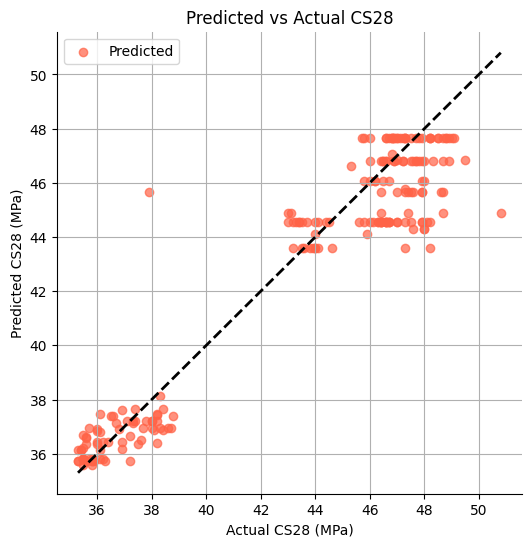

Fold: 2
******
[TRAIN]
******
RMSE: 1.552 (0.000)
MAE: 0.931 (0.000)
MAPE: 0.022 (0.000)
R2: 0.901 (0.000)


******
[TEST]
******
RMSE: 1.552 (0.000)
MAE: 0.931 (0.000)
MAPE: 0.022 (0.000)
R2: 0.901 (0.000)




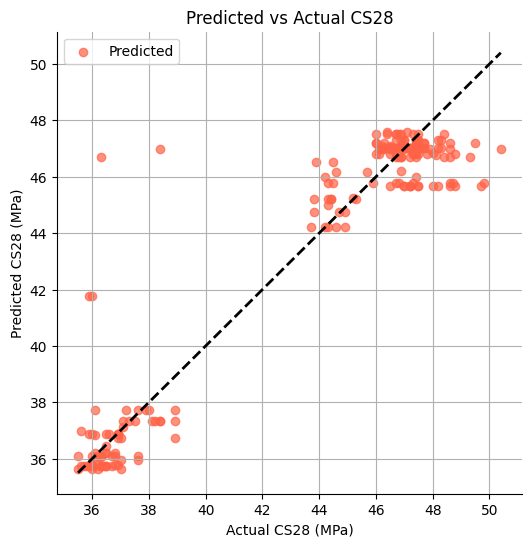

Fold: 3
******
[TRAIN]
******
RMSE: 1.606 (0.000)
MAE: 0.949 (0.000)
MAPE: 0.023 (0.000)
R2: 0.903 (0.000)


******
[TEST]
******
RMSE: 1.606 (0.000)
MAE: 0.949 (0.000)
MAPE: 0.023 (0.000)
R2: 0.903 (0.000)




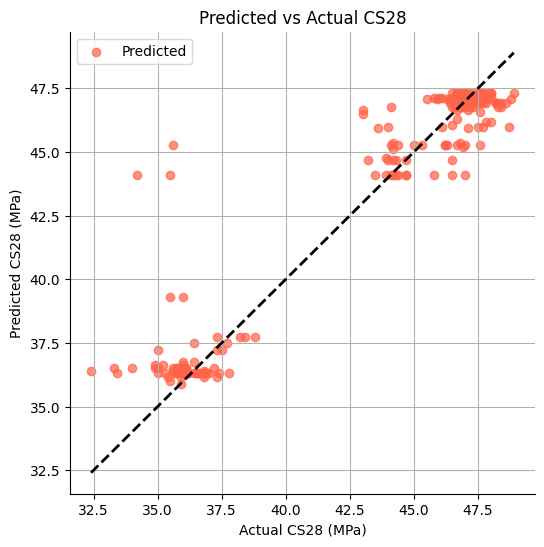

Fold: 4
******
[TRAIN]
******
RMSE: 1.867 (0.000)
MAE: 1.499 (0.000)
MAPE: 0.033 (0.000)
R2: 0.880 (0.000)


******
[TEST]
******
RMSE: 1.867 (0.000)
MAE: 1.499 (0.000)
MAPE: 0.033 (0.000)
R2: 0.880 (0.000)




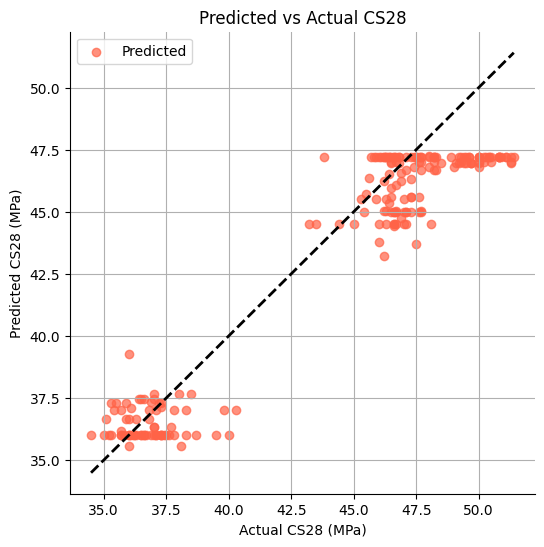

Fold: 5
******
[TRAIN]
******
RMSE: 1.461 (0.000)
MAE: 1.083 (0.000)
MAPE: 0.025 (0.000)
R2: 0.909 (0.000)


******
[TEST]
******
RMSE: 1.461 (0.000)
MAE: 1.083 (0.000)
MAPE: 0.025 (0.000)
R2: 0.909 (0.000)




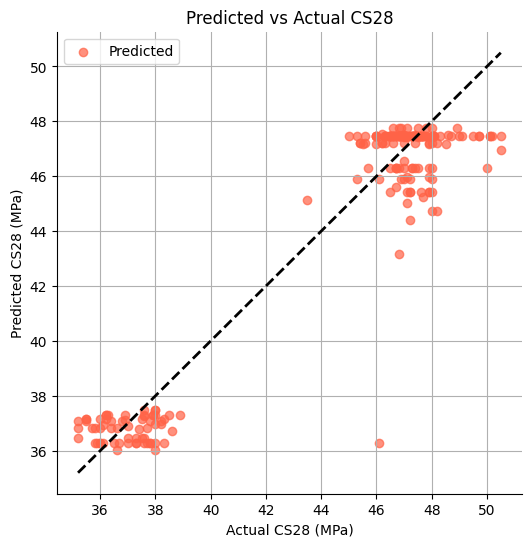

<IPython.core.display.Javascript object>

In [20]:
test_data = df_pred[df_pred["SET"] == "TEST"]

for fold in test_data["FOLD"].unique():
    test_data_f = test_data[test_data["FOLD"].eq(fold)]
    print("Fold:", fold)
    real = test_data_f["CS28"]
    pred = test_data_f["CS28_PRED"]
    results = score_regression_metrics(real, pred, real, pred)
    print_scores(results, METRICS, METRICS_DICT)
    plt.figure(figsize=(6, 6))
    plt.scatter(
        real,
        pred,
        color="tomato",
        alpha=0.7,
        label="Predicted",
    )
    plt.plot(
        [real.min(), real.max()],
        [real.min(), real.max()],
        color="black",
        linestyle="--",
        linewidth=2,
    )
    plt.xlabel("Actual CS28 (MPa)")
    plt.ylabel("Predicted CS28 (MPa)")
    plt.title("Predicted vs Actual CS28")
    plt.legend()
    plt.grid(True)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.show()

Fold: 1
******
[TRAIN]
******
RMSE: 1.569 (0.000)
MAE: 1.140 (0.000)
MAPE: 0.026 (0.000)
R2: 0.900 (0.000)


******
[TEST]
******
RMSE: 1.569 (0.000)
MAE: 1.140 (0.000)
MAPE: 0.026 (0.000)
R2: 0.900 (0.000)


Fold: 2
******
[TRAIN]
******
RMSE: 1.552 (0.000)
MAE: 0.931 (0.000)
MAPE: 0.022 (0.000)
R2: 0.901 (0.000)


******
[TEST]
******
RMSE: 1.552 (0.000)
MAE: 0.931 (0.000)
MAPE: 0.022 (0.000)
R2: 0.901 (0.000)


Fold: 3
******
[TRAIN]
******
RMSE: 1.606 (0.000)
MAE: 0.949 (0.000)
MAPE: 0.023 (0.000)
R2: 0.903 (0.000)


******
[TEST]
******
RMSE: 1.606 (0.000)
MAE: 0.949 (0.000)
MAPE: 0.023 (0.000)
R2: 0.903 (0.000)


Fold: 4
******
[TRAIN]
******
RMSE: 1.867 (0.000)
MAE: 1.499 (0.000)
MAPE: 0.033 (0.000)
R2: 0.880 (0.000)


******
[TEST]
******
RMSE: 1.867 (0.000)
MAE: 1.499 (0.000)
MAPE: 0.033 (0.000)
R2: 0.880 (0.000)


Fold: 5
******
[TRAIN]
******
RMSE: 1.461 (0.000)
MAE: 1.083 (0.000)
MAPE: 0.025 (0.000)
R2: 0.909 (0.000)


******
[TEST]
******
RMSE: 1.461 (0.000)
MAE: 1.083 (0.

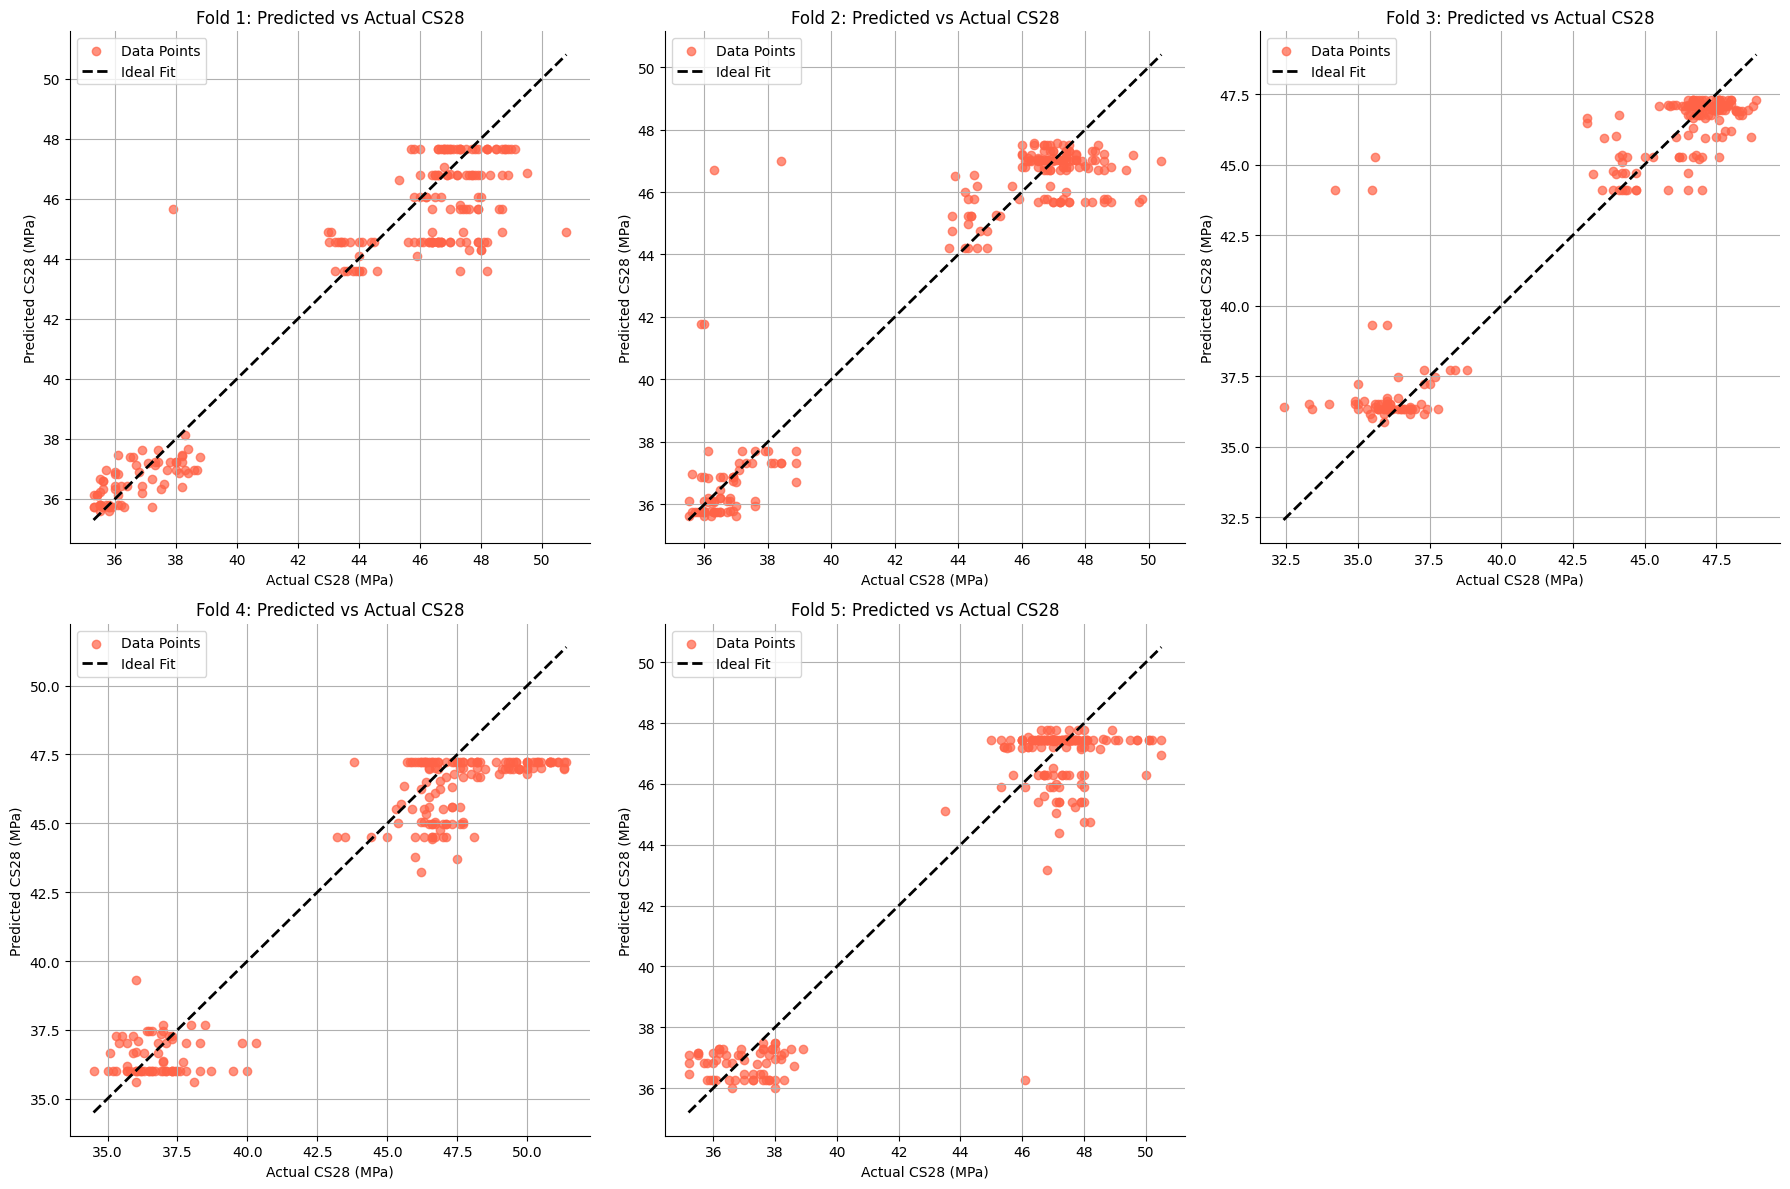

<IPython.core.display.Javascript object>

In [21]:
import matplotlib.pyplot as plt

# Assuming df_pred is already defined and contains your data
test_data = df_pred[df_pred["SET"] == "TEST"]
folds = sorted(test_data["FOLD"].unique())

# Create a figure with subplots: 2 rows x 3 columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flatten()

for i, fold in enumerate(folds):
    test_data_f = test_data[test_data["FOLD"] == fold]
    print("Fold:", fold)
    real = test_data_f["CS28"]
    pred = test_data_f["CS28_PRED"]
    results = score_regression_metrics(real, pred, real, pred)
    print_scores(results, METRICS, METRICS_DICT)
    
    ax = axes[i]
    ax.scatter(
        real,
        pred,
        color="tomato",
        alpha=0.7,
        label="Data Points",
    )
    ax.plot(
        [real.min(), real.max()],
        [real.min(), real.max()],
        color="black",
        linestyle="--",
        linewidth=2,
        label="Ideal Fit",
    )
    ax.set_xlabel("Actual CS28 (MPa)")
    ax.set_ylabel("Predicted CS28 (MPa)")
    ax.set_title(f"Fold {fold}: Predicted vs Actual CS28")
    ax.legend()
    ax.grid(True)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# Remove any unused subplots if the number of folds is less than the number of subplots
for j in range(len(folds), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Fold: 1
******
[TRAIN]
******
RMSE: 1.569 (0.000)
MAE: 1.140 (0.000)
MAPE: 0.026 (0.000)
R2: 0.900 (0.000)


******
[TEST]
******
RMSE: 1.569 (0.000)
MAE: 1.140 (0.000)
MAPE: 0.026 (0.000)
R2: 0.900 (0.000)


Fold: 2
******
[TRAIN]
******
RMSE: 1.552 (0.000)
MAE: 0.931 (0.000)
MAPE: 0.022 (0.000)
R2: 0.901 (0.000)


******
[TEST]
******
RMSE: 1.552 (0.000)
MAE: 0.931 (0.000)
MAPE: 0.022 (0.000)
R2: 0.901 (0.000)


Fold: 3
******
[TRAIN]
******
RMSE: 1.606 (0.000)
MAE: 0.949 (0.000)
MAPE: 0.023 (0.000)
R2: 0.903 (0.000)


******
[TEST]
******
RMSE: 1.606 (0.000)
MAE: 0.949 (0.000)
MAPE: 0.023 (0.000)
R2: 0.903 (0.000)


Fold: 4
******
[TRAIN]
******
RMSE: 1.867 (0.000)
MAE: 1.499 (0.000)
MAPE: 0.033 (0.000)
R2: 0.880 (0.000)


******
[TEST]
******
RMSE: 1.867 (0.000)
MAE: 1.499 (0.000)
MAPE: 0.033 (0.000)
R2: 0.880 (0.000)


Fold: 5
******
[TRAIN]
******
RMSE: 1.461 (0.000)
MAE: 1.083 (0.000)
MAPE: 0.025 (0.000)
R2: 0.909 (0.000)


******
[TEST]
******
RMSE: 1.461 (0.000)
MAE: 1.083 (0.

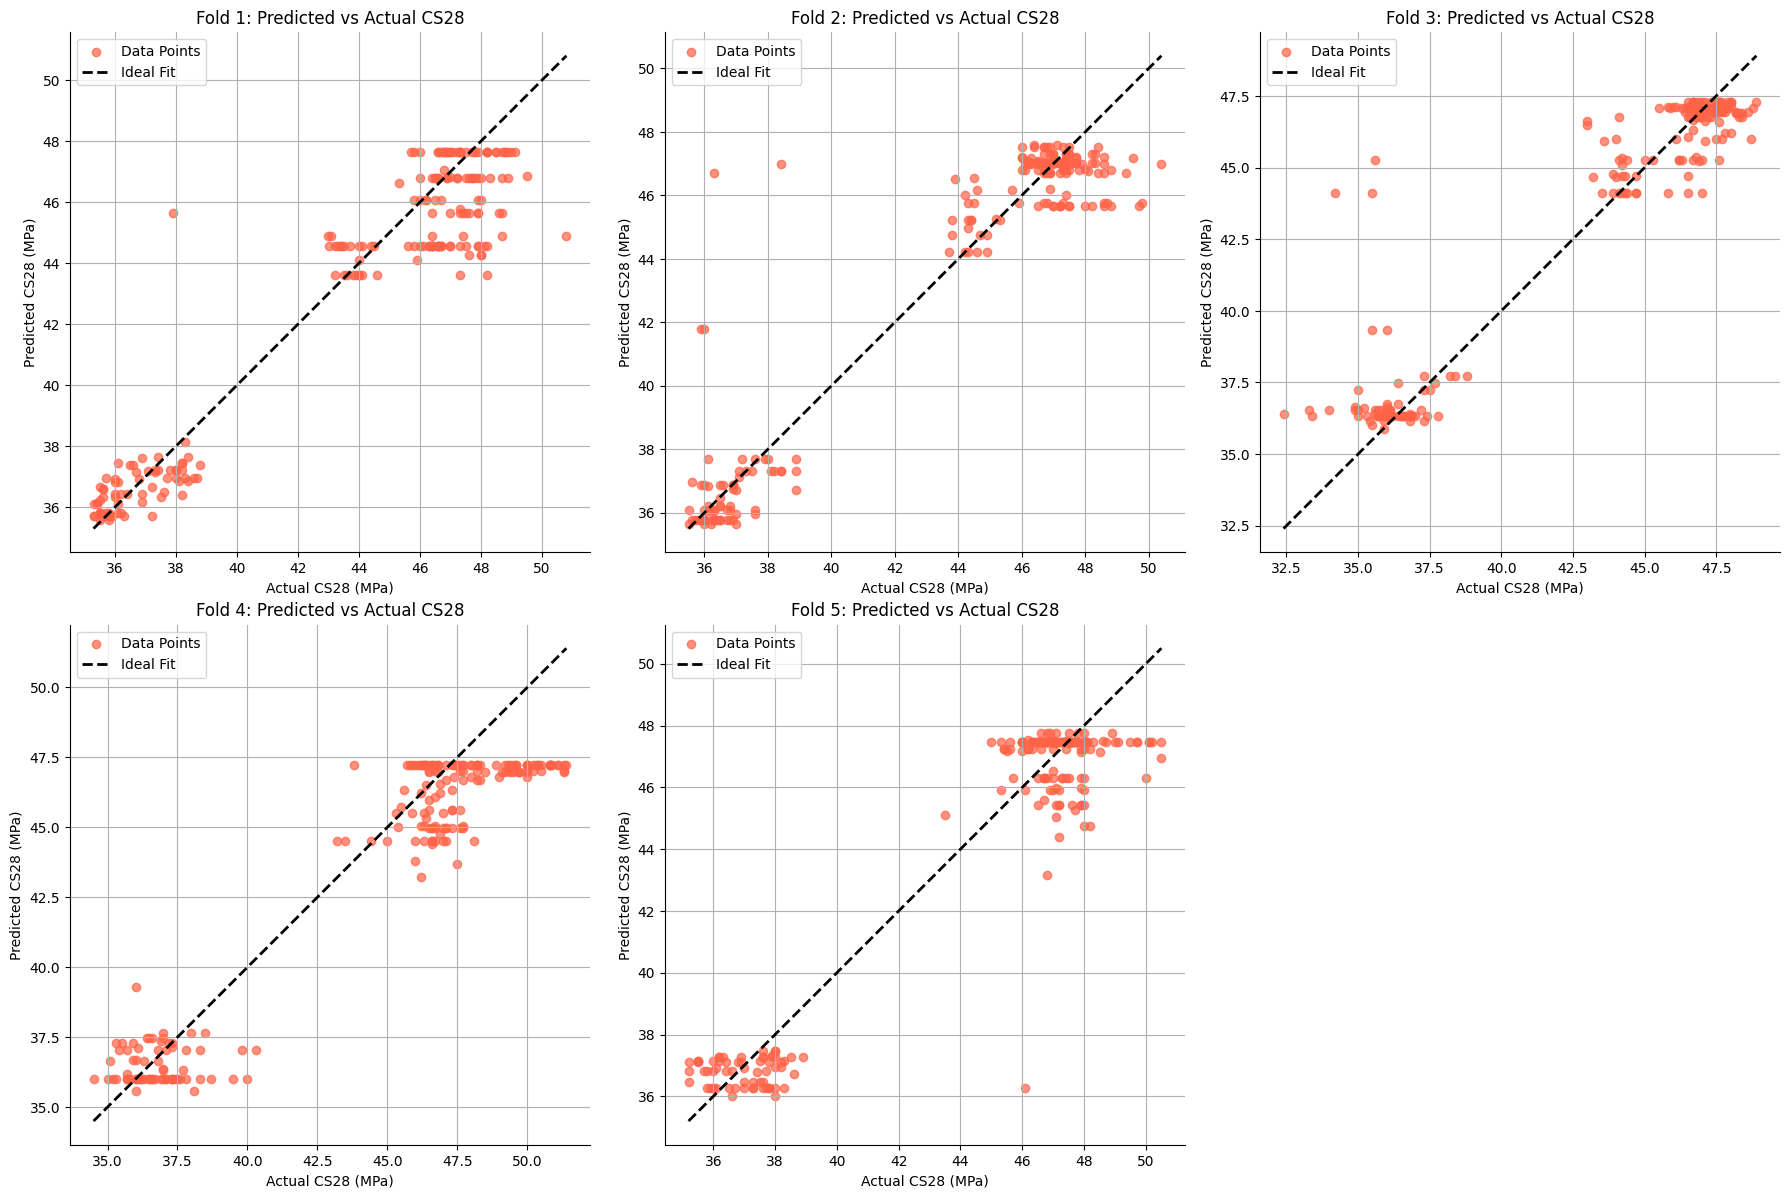

<IPython.core.display.Javascript object>

In [22]:
import matplotlib.pyplot as plt

# Assuming df_pred is already defined and contains your data
test_data = df_pred[df_pred["SET"] == "TEST"]
folds = sorted(test_data["FOLD"].unique())

# Number of folds
num_folds = len(folds)

# Determine the number of rows and columns for subplots
# For 5 folds, we'll use a 2x3 grid (will have one empty subplot)
cols = 3
rows = 2

# Create a figure with subplots: adjust figsize to ensure square subplots
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 6, rows * 6))
axes = axes.flatten()

for i, fold in enumerate(folds):
    test_data_f = test_data[test_data["FOLD"] == fold]
    print("Fold:", fold)
    real = test_data_f["CS28"]
    pred = test_data_f["CS28_PRED"]
    results = score_regression_metrics(real, pred, real, pred)
    print_scores(results, METRICS, METRICS_DICT)
    
    ax = axes[i]
    ax.scatter(
        real,
        pred,
        color="tomato",
        alpha=0.7,
        label="Data Points",
    )
    ax.plot(
        [real.min(), real.max()],
        [real.min(), real.max()],
        color="black",
        linestyle="--",
        linewidth=2,
        label="Ideal Fit",
    )
    ax.set_xlabel("Actual CS28 (MPa)")
    ax.set_ylabel("Predicted CS28 (MPa)")
    ax.set_title(f"Fold {fold}: Predicted vs Actual CS28")
    ax.legend()
    ax.grid(True)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_aspect('equal', adjustable='box')  # Ensure the subplot is square

# Remove any unused subplots if the number of folds is less than the number of subplots
for j in range(num_folds, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [23]:
df_pred["SET"].value_counts()

SET
TRAIN    3070
TEST     1020
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [24]:
tel = 0
tal = 0
for train, test in cv.split(x):
    tal += len(train)
    tel += len(test)
    print(tal, tel, len(test))

206 204 204
616 408 204
1230 612 204
2048 816 204
3070 1020 204


<IPython.core.display.Javascript object>

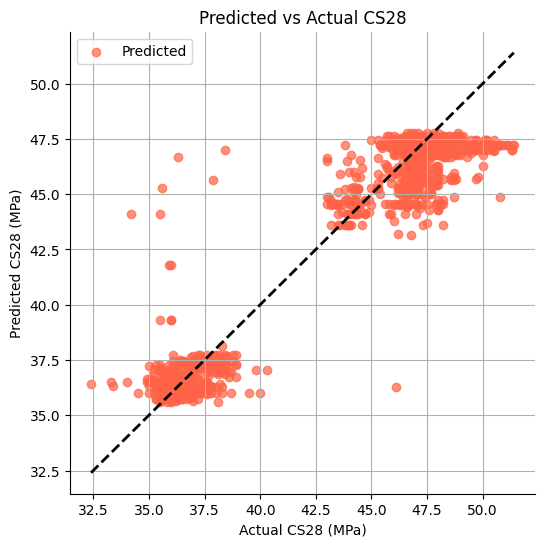

<IPython.core.display.Javascript object>

In [25]:
# Scatter plot of actual vs predicted values
test_data = df_pred[df_pred["SET"] == "TEST"]
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "inn_cm_p_tiss_scpm_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches="tight"
)
plt.show()

In [26]:
train_data = df_pred[df_pred["SET"] == "TRAIN"]
cs = []

for fold in train_data["FOLD"].unique():
    train_data_fold = train_data[train_data["FOLD"].eq(fold)]
    c = (
        train_data_fold[train_data_fold["CS28"] > 42]["CS28"].std(),
        train_data_fold[train_data_fold["CS28"] < 42]["CS28"].std(),
    )
    cs.append(c)
    print(c)

s = (
    train_data[train_data["CS28"] > 42]["CS28"].std(),
    train_data[train_data["CS28"] < 42]["CS28"].std(),
)
print()
print(s)
print()

print()
print(np.mean(cs))
print()

(1.7809606152871171, 1.11973181986388)
(1.7042088462837561, 1.1007566399597313)
(1.5961071540461482, 1.0249021298477408)
(1.5426202903548445, 1.0814506695718968)
(1.6530293179767104, 1.1068636569880972)

(1.6324909884761305, 1.0840670924109994)


1.371063114017992



<IPython.core.display.Javascript object>

In [27]:
df[df["CS28"] > 42]["CS28"].std(), df[df["CS28"] < 42]["CS28"].std()

(1.5793911491529553, 1.0966443963921526)

<IPython.core.display.Javascript object>

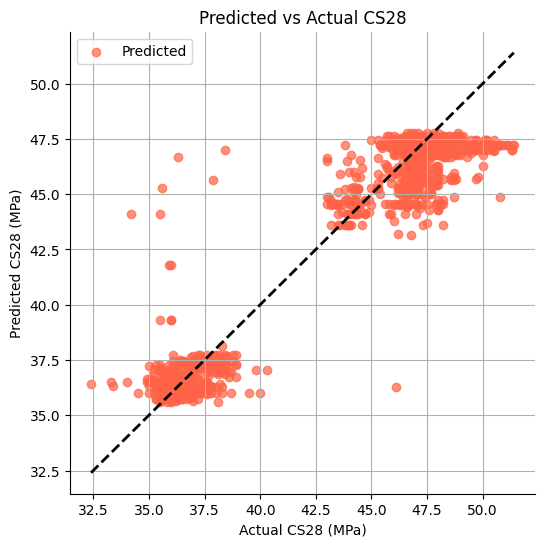

<IPython.core.display.Javascript object>

In [28]:
# Scatter plot of actual vs predicted values
test_data = df_pred[df_pred["SET"] == "TEST"]
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "inn_cm_p_tiss_scpm_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches="tight"
)
plt.show()

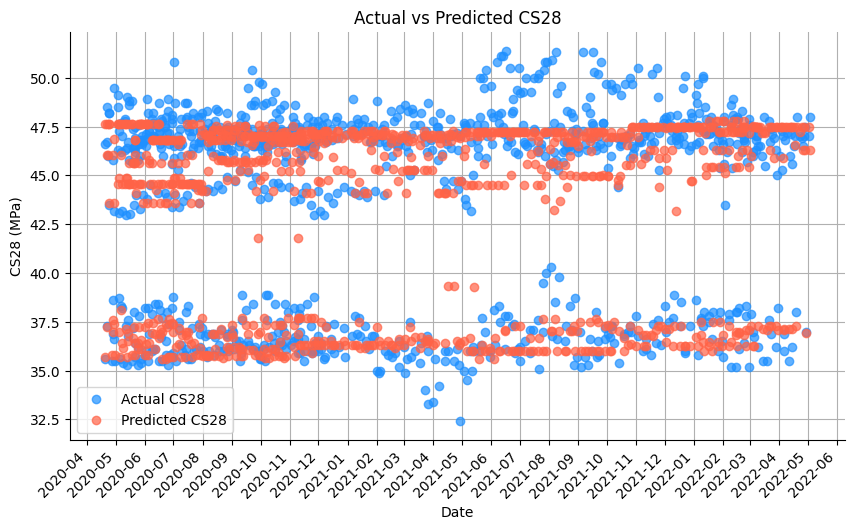

<IPython.core.display.Javascript object>

In [29]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

# Improving x-axis readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set ticks for each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format date as 'YYYY-MM-DD'
plt.gcf().autofmt_xdate(rotation=45)  # Rotate x-axis labels

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "inn_cm_p_tiss_scpm_top_one_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


In [30]:
len(test_data), 175 * 5

(1020, 875)

<IPython.core.display.Javascript object>

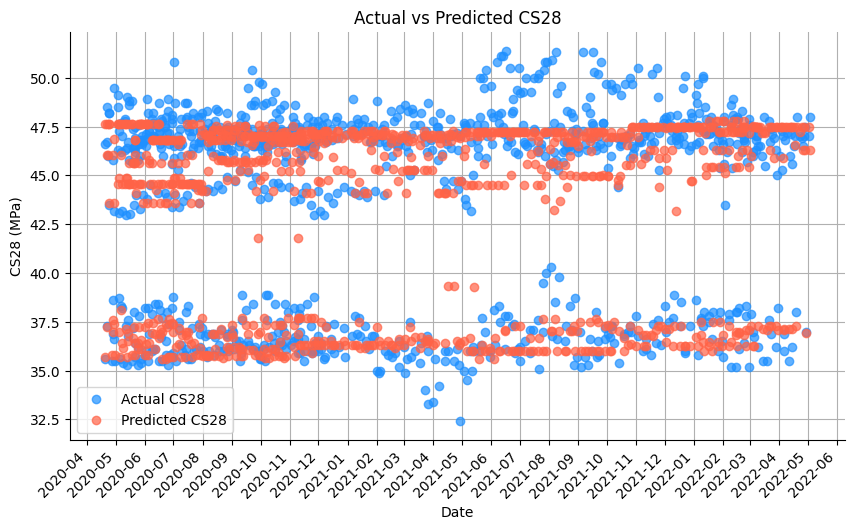

<IPython.core.display.Javascript object>

In [31]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

# Improving x-axis readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set ticks for each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format date as 'YYYY-MM-DD'
plt.gcf().autofmt_xdate(rotation=45)  # Rotate x-axis labels

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "inn_cm_p_tiss_scpm_top_one_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


## Assessing Feature Importance

In [32]:
df_importances = get_random_forest_df_importances(scores)

<IPython.core.display.Javascript object>

In [33]:
df_importances

,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,Fe2O3,Loss on Ignition,Insoluble Residue,...,Anhydrite,Calcite,Dolomite,Quartz,Blaine,Initial setting time,Final setting time,Density,#200,#325
Importances - 0,0.001804,0.048838,0.0,0.000000,0.000000,0.000086,0.000000,0.021667,0.000294,0.0,...,0.0,0.000000,0.0,0.001052,0.010099,0.0,0.000000,0.000000,0.361440,0.549751
Importances - 1,0.000000,0.032963,0.0,0.000000,0.000000,0.000344,0.000958,0.000000,0.004020,0.0,...,0.0,0.000000,0.0,0.006018,0.008750,0.0,0.000000,0.000000,0.564940,0.378268
Importances - 2,0.000716,0.011841,0.0,0.000000,0.000282,0.000254,0.000000,0.004491,0.003805,0.0,...,0.0,0.004248,0.0,0.005633,0.017970,0.0,0.000000,0.000000,0.000237,0.949613
Importances - 3,0.000000,0.011765,0.0,0.000390,0.000000,0.000160,0.000000,0.003388,0.001388,0.0,...,0.0,0.001630,0.0,0.001571,0.018461,0.0,0.000252,0.007822,0.006441,0.945346
Importances - 4,0.000309,0.007547,0.0,0.000326,0.000000,0.000401,0.000000,0.004376,0.000000,0.0,...,0.0,0.002889,0.0,0.000997,0.020002,0.0,0.000000,0.003453,0.003359,0.953973


<IPython.core.display.Javascript object>

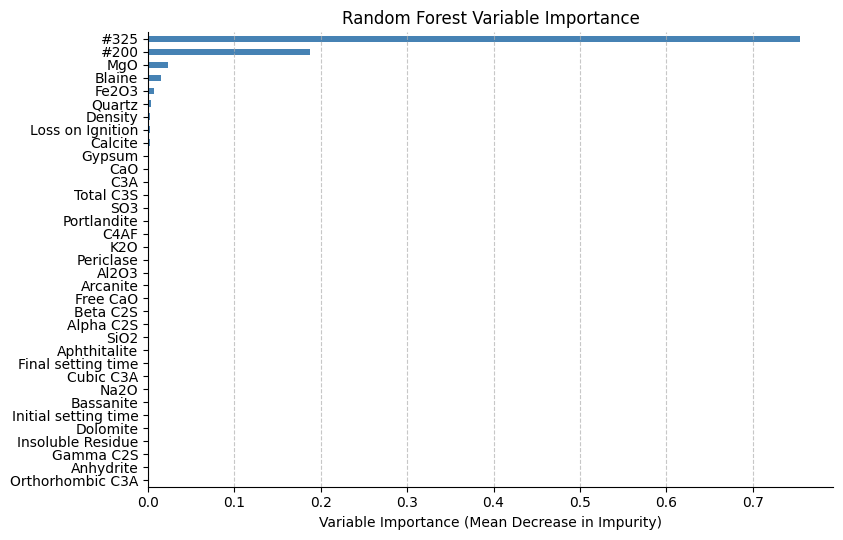

<IPython.core.display.Javascript object>

In [34]:
df_importances.mean(axis=0).sort_values().plot(
    kind="barh", figsize=(10, 5.5), color="steelblue"  # Consider using 'steelblue'
)
plt.title("Random Forest Variable Importance")
plt.xlabel("Variable Importance (Mean Decrease in Impurity)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.subplots_adjust(left=0.3)
plt.show()

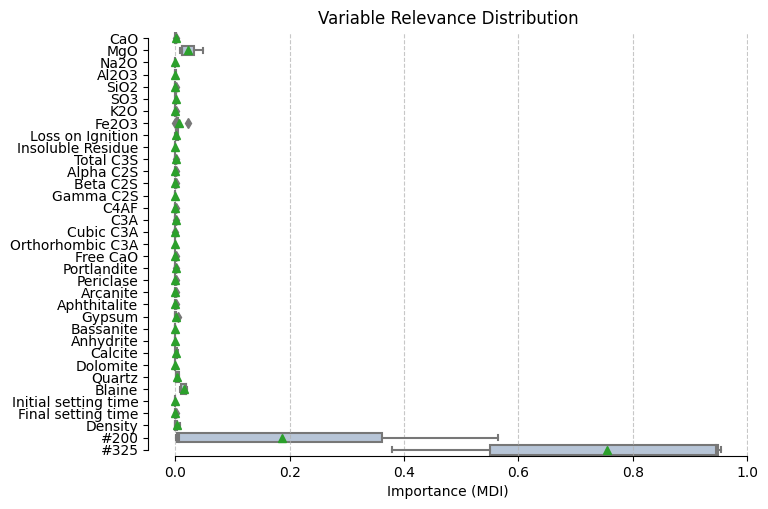

<IPython.core.display.Javascript object>

In [35]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=df_importances, orient="h", color="lightsteelblue", saturation=0.7, showmeans=True)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (MDI)")
plt.title("Variable Relevance Distribution")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.show()


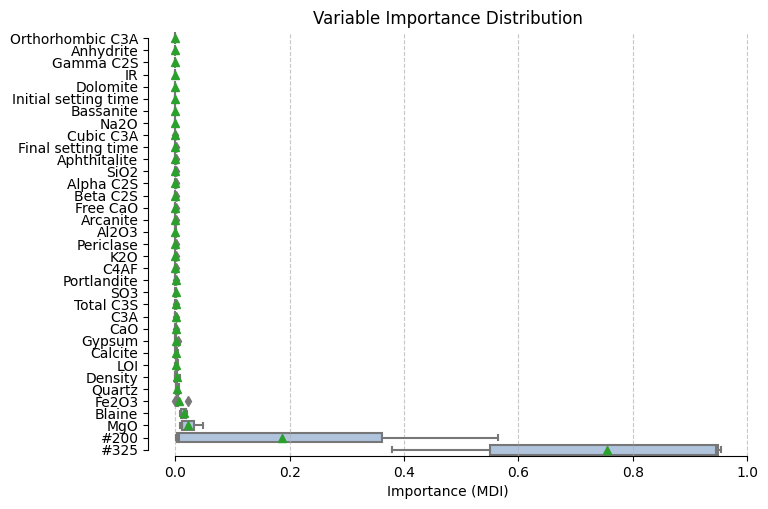

<IPython.core.display.Javascript object>

In [36]:
# Calculate the means of the importance scores
mean_importances = df_importances.mean()

# Sort the features by their mean relevance
sorted_features = mean_importances.sort_values()

# Re-order the DataFrame according to the sorted features
df_importances_sorted = df_importances[sorted_features.index]

# Plot the sorted boxplot
df_importances_sorted = df_importances_sorted.rename(
    columns={"Loss on Ignition": "LOI", "Insoluble Residue": "IR"}
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (MDI)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "inn_cm_p_tiss_random_forest_scpm_best_dist_var_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [37]:
print("Default font family:", matplotlib.rcParams["font.family"])
print("Default sans-serif fonts:", matplotlib.rcParams["font.sans-serif"])
print("Default font size:", matplotlib.rcParams["font.size"])
print("Default font weight:", matplotlib.rcParams["font.weight"])

Default font family: ['sans-serif']
Default sans-serif fonts: ['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Arial', 'Helvetica', 'Avant Garde', 'sans-serif']
Default font size: 10.0
Default font weight: normal


<IPython.core.display.Javascript object>

In [38]:
plt.get_backend()

'module://matplotlib_inline.backend_inline'

<IPython.core.display.Javascript object>

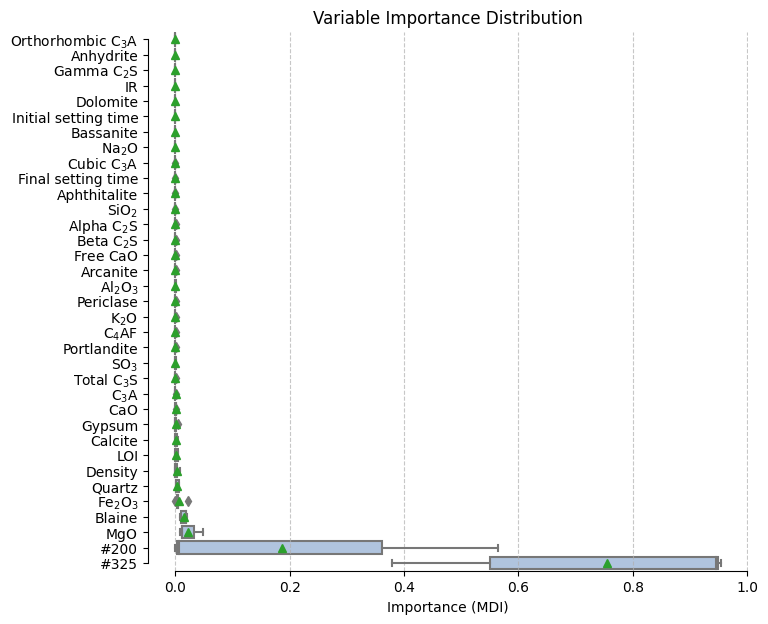

<IPython.core.display.Javascript object>

In [39]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
df_importances_sorted_plot = df_importances_sorted.rename(
    columns={
        "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
    }
)

plt.figure(figsize=(10, 7))
sns.boxplot(
    data=df_importances_sorted_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (MDI)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "inn_cm_p_tiss_random_forest_scpm_best_dist_var_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

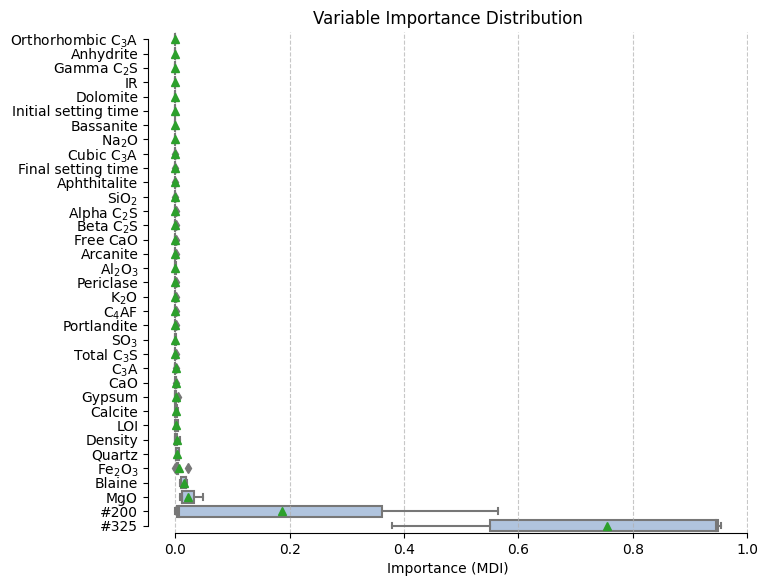

<IPython.core.display.Javascript object>

In [40]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
df_importances_sorted_plot = df_importances_sorted.rename(
    columns={
        "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
    }
)

plt.figure(figsize=(10, 6.5))
sns.boxplot(
    data=df_importances_sorted_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (MDI)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)

plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [41]:
df_importances

,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,Fe2O3,Loss on Ignition,Insoluble Residue,...,Anhydrite,Calcite,Dolomite,Quartz,Blaine,Initial setting time,Final setting time,Density,#200,#325
Importances - 0,0.001804,0.048838,0.0,0.000000,0.000000,0.000086,0.000000,0.021667,0.000294,0.0,...,0.0,0.000000,0.0,0.001052,0.010099,0.0,0.000000,0.000000,0.361440,0.549751
Importances - 1,0.000000,0.032963,0.0,0.000000,0.000000,0.000344,0.000958,0.000000,0.004020,0.0,...,0.0,0.000000,0.0,0.006018,0.008750,0.0,0.000000,0.000000,0.564940,0.378268
Importances - 2,0.000716,0.011841,0.0,0.000000,0.000282,0.000254,0.000000,0.004491,0.003805,0.0,...,0.0,0.004248,0.0,0.005633,0.017970,0.0,0.000000,0.000000,0.000237,0.949613
Importances - 3,0.000000,0.011765,0.0,0.000390,0.000000,0.000160,0.000000,0.003388,0.001388,0.0,...,0.0,0.001630,0.0,0.001571,0.018461,0.0,0.000252,0.007822,0.006441,0.945346
Importances - 4,0.000309,0.007547,0.0,0.000326,0.000000,0.000401,0.000000,0.004376,0.000000,0.0,...,0.0,0.002889,0.0,0.000997,0.020002,0.0,0.000000,0.003453,0.003359,0.953973


<IPython.core.display.Javascript object>

In [42]:
df_importances.describe().T

,count,mean,std,min,25%,50%,75%,max
CaO,5.0,0.000566,0.000752,0.000000,0.000000,0.000309,0.000716,0.001804
MgO,5.0,0.022591,0.017717,0.007547,0.011765,0.011841,0.032963,0.048838
Na2O,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Al2O3,5.0,0.000143,0.000197,0.000000,0.000000,0.000000,0.000326,0.000390
SiO2,5.0,0.000056,0.000126,0.000000,0.000000,0.000000,0.000000,0.000282
SO3,5.0,0.000249,0.000129,0.000086,0.000160,0.000254,0.000344,0.000401
K2O,5.0,0.000192,0.000429,0.000000,0.000000,0.000000,0.000000,0.000958
Fe2O3,5.0,0.006785,0.008516,0.000000,0.003388,0.004376,0.004491,0.021667
Loss on Ignition,5.0,0.001901,0.001909,0.000000,0.000294,0.001388,0.003805,0.004020
Insoluble Residue,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<IPython.core.display.Javascript object>

In [43]:
df_importances.mean(axis=0)

CaO                     0.000566
MgO                     0.022591
Na2O                    0.000000
Al2O3                   0.000143
SiO2                    0.000056
SO3                     0.000249
K2O                     0.000192
Fe2O3                   0.006785
Loss on Ignition        0.001901
Insoluble Residue       0.000000
Total C3S               0.000277
Alpha C2S               0.000082
Beta C2S                0.000086
Gamma C2S               0.000000
C4AF                    0.000209
C3A                     0.000314
Cubic C3A               0.000007
Orthorhombic C3A        0.000000
Free CaO                0.000103
Portlandite             0.000239
Periclase               0.000177
Arcanite                0.000142
Aphthitalite            0.000054
Gypsum                  0.000984
Bassanite               0.000000
Anhydrite               0.000000
Calcite                 0.001753
Dolomite                0.000000
Quartz                  0.003054
Blaine                  0.015056
Initial se

<IPython.core.display.Javascript object>

In [44]:
df_importances.std(axis=0)

CaO                     0.000752
MgO                     0.017717
Na2O                    0.000000
Al2O3                   0.000197
SiO2                    0.000126
SO3                     0.000129
K2O                     0.000429
Fe2O3                   0.008516
Loss on Ignition        0.001909
Insoluble Residue       0.000000
Total C3S               0.000620
Alpha C2S               0.000184
Beta C2S                0.000193
Gamma C2S               0.000000
C4AF                    0.000442
C3A                     0.000596
Cubic C3A               0.000016
Orthorhombic C3A        0.000000
Free CaO                0.000230
Portlandite             0.000535
Periclase               0.000395
Arcanite                0.000318
Aphthitalite            0.000120
Gypsum                  0.001818
Bassanite               0.000000
Anhydrite               0.000000
Calcite                 0.001849
Dolomite                0.000000
Quartz                  0.002543
Blaine                  0.005218
Initial se

<IPython.core.display.Javascript object>

In [45]:
df_importances.std(axis=0, ddof=0)

CaO                     0.000673
MgO                     0.015846
Na2O                    0.000000
Al2O3                   0.000177
SiO2                    0.000113
SO3                     0.000115
K2O                     0.000383
Fe2O3                   0.007617
Loss on Ignition        0.001707
Insoluble Residue       0.000000
Total C3S               0.000555
Alpha C2S               0.000164
Beta C2S                0.000173
Gamma C2S               0.000000
C4AF                    0.000395
C3A                     0.000533
Cubic C3A               0.000014
Orthorhombic C3A        0.000000
Free CaO                0.000206
Portlandite             0.000479
Periclase               0.000353
Arcanite                0.000284
Aphthitalite            0.000107
Gypsum                  0.001626
Bassanite               0.000000
Anhydrite               0.000000
Calcite                 0.001654
Dolomite                0.000000
Quartz                  0.002275
Blaine                  0.004667
Initial se

<IPython.core.display.Javascript object>

In [46]:
df_copy.nunique()

Date                     651
CaO                     1215
MgO                     1216
Na2O                    1107
Al2O3                   1208
SiO2                    1213
SO3                     1213
K2O                     1178
Fe2O3                   1207
Loss on Ignition         579
Insoluble Residue        410
Total C3S                882
Alpha C2S                335
Beta C2S                 626
Gamma C2S                178
C4AF                     451
C3A                      310
Cubic C3A                278
Orthorhombic C3A         204
Free CaO                 167
Portlandite              292
Periclase                247
Arcanite                 267
Aphthitalite             104
Gypsum                   383
Bassanite                472
Anhydrite                 48
Calcite                  810
Dolomite                 293
Quartz                   256
Blaine                   349
Initial setting time      17
Final setting time        17
Density                   10
#200          

<IPython.core.display.Javascript object>

In [47]:
pipeline.named_steps

{'imputer': SimpleImputer(strategy='median'),
 'estimator': RandomForestRegressor(max_depth=3, n_estimators=5, random_state=47)}

<IPython.core.display.Javascript object>

In [48]:
from sklearn.inspection import permutation_importance

<IPython.core.display.Javascript object>

In [49]:
# Initialize lists to store importance results
mdi_importances = []
perm_importances = []

# Compute feature importances
for i, (train_idx, test_idx) in enumerate(cv.split(x, y)):
    pipeline.fit(x.iloc[train_idx], y[train_idx])

    # Extract the trained model
    model = pipeline.named_steps["estimator"]
    imputer = pipeline.named_steps["imputer"]
    # Compute MDI importance
    mdi_importances.append(model.feature_importances_)

    # Compute permutation importance
    result = permutation_importance(
        model,
        imputer.transform(x.iloc[test_idx]),
        y[test_idx],
        n_repeats=10,
        random_state=SEED,
        n_jobs=-1,
        # scoring="neg_mean_squared_error",
        scoring="r2",
    )
    perm_importances.append(result.importances_mean)

<IPython.core.display.Javascript object>

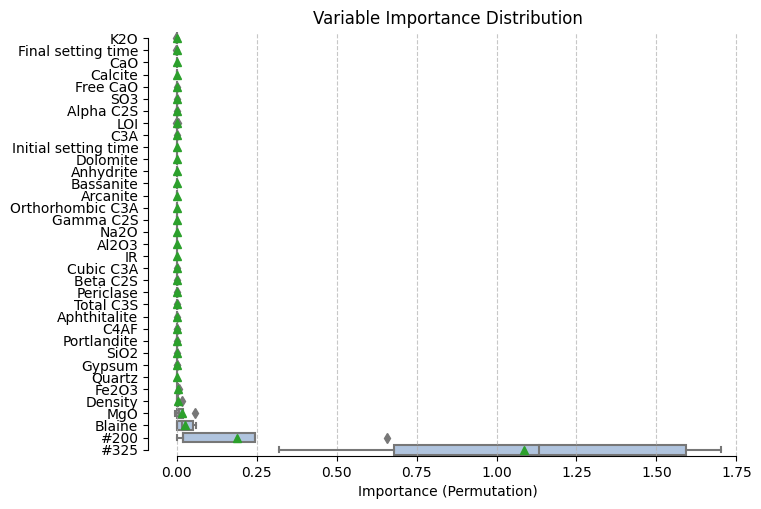

<IPython.core.display.Javascript object>

In [50]:
# Convert lists to DataFrames
mdi_importances_df = pd.DataFrame(mdi_importances, columns=x.columns)
perm_importances_df = pd.DataFrame(perm_importances, columns=x.columns)


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]

perm_importances_df = perm_importances_df.rename(
    columns={"Loss on Ignition": "LOI", "Insoluble Residue": "IR"}
)


plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "inn_cm_p_tiss_random_forest_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

# # Step 3: Reset all rcParams to their default values
plt.rcdefaults()

plt.show()

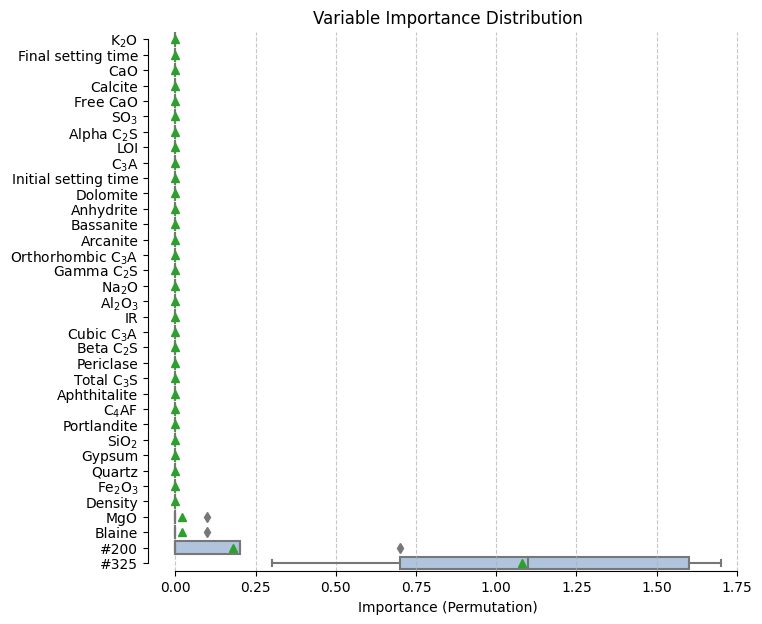

<IPython.core.display.Javascript object>

In [51]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
    }
)

plt.figure(figsize=(10, 7))
sns.boxplot(
    data=perm_importances_df_plot.round(1),
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "inn_cm_p_tiss_random_forest_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

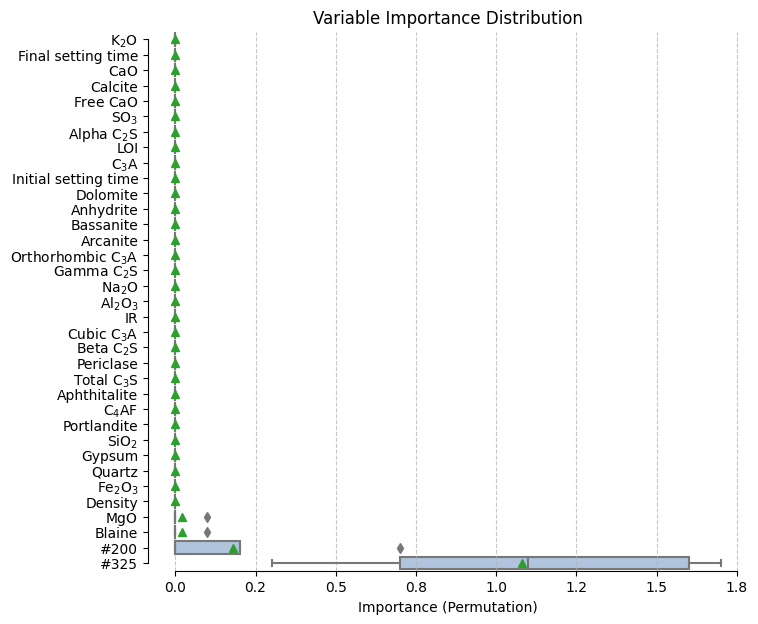

<IPython.core.display.Javascript object>

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
    }
)

plt.figure(figsize=(10, 7))

# Create boxplot
sns.boxplot(
    data=perm_importances_df_plot.round(1),
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)

# Set x-axis label and title
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")

# Add gridlines for x-axis
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Format x-axis to show 1 decimal place
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.1f}'))

# Adjust the layout to prevent label cut-off
plt.subplots_adjust(left=0.3)

# Save the plot
plt.savefig(
    "inn_cm_p_tiss_random_forest_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

# Show the plot
plt.show()

# Reset all rcParams to their default values
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)


In [53]:
perm_importances_df.describe().round(4).T

,count,mean,std,min,25%,50%,75%,max
K2O,5.0,-0.0002,0.0005,-0.0010,0.0000,0.0000,0.0000,0.0000
Final setting time,5.0,-0.0002,0.0004,-0.0009,0.0000,0.0000,0.0000,0.0000
CaO,5.0,-0.0002,0.0003,-0.0005,-0.0004,0.0000,0.0000,0.0001
Calcite,5.0,-0.0001,0.0003,-0.0005,-0.0003,0.0000,0.0000,0.0002
Free CaO,5.0,-0.0001,0.0002,-0.0004,0.0000,0.0000,0.0000,0.0000
SO3,5.0,-0.0000,0.0005,-0.0008,0.0000,0.0001,0.0002,0.0003
Alpha C2S,5.0,-0.0000,0.0001,-0.0001,0.0000,0.0000,0.0000,0.0000
LOI,5.0,-0.0000,0.0021,-0.0032,-0.0002,0.0000,0.0004,0.0028
C3A,5.0,-0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000
Initial setting time,5.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


<IPython.core.display.Javascript object>

In [54]:
perm_importances_df

,K2O,Final setting time,CaO,Calcite,Free CaO,SO3,Alpha C2S,LOI,C3A,Initial setting time,...,Portlandite,SiO2,Gypsum,Quartz,Fe2O3,Density,MgO,Blaine,#200,#325
0,0.000000,0.000000,-0.000504,0.000000,-0.000371,0.000005,0.000000,-0.000168,0.000000,0.0,...,0.000000,0.000000,0.001689,-0.000034,0.007599,0.000000,0.055988,0.002242,0.245063,0.678216
1,-0.001009,0.000000,0.000000,0.000000,0.000000,0.000202,-0.000138,-0.003162,0.000000,0.0,...,0.000334,0.000000,-0.000137,-0.000124,0.000000,0.000000,0.018094,0.015830,0.656594,0.318343
2,0.000000,0.000000,-0.000378,-0.000516,0.000000,0.000309,0.000000,0.002845,-0.000028,0.0,...,0.000000,0.000904,0.000000,0.001586,-0.000098,0.000000,0.007466,0.060022,0.000286,1.701341
3,0.000000,-0.000915,0.000000,0.000200,0.000000,0.000141,0.000000,0.000448,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000136,0.002930,0.017539,-0.000744,0.049710,0.019022,1.133714
4,0.000000,0.000000,0.000125,-0.000316,0.000000,-0.000837,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000753,0.002483,0.005393,-0.004384,0.000457,0.019405,1.591699


<IPython.core.display.Javascript object>

In [55]:
perm_importances_df.mean(axis=0)

K2O                    -2.017328e-04
Final setting time     -1.829274e-04
CaO                    -1.512878e-04
Calcite                -1.262841e-04
Free CaO               -7.421828e-05
SO3                    -3.594324e-05
Alpha C2S              -2.752652e-05
LOI                    -7.495459e-06
C3A                    -5.612901e-06
Initial setting time    0.000000e+00
Dolomite                0.000000e+00
Anhydrite               0.000000e+00
Bassanite               0.000000e+00
Arcanite                0.000000e+00
Orthorhombic C3A        0.000000e+00
Gamma C2S               0.000000e+00
Na2O                    0.000000e+00
Al2O3                   0.000000e+00
IR                      0.000000e+00
Cubic C3A               6.854296e-08
Beta C2S                1.677842e-06
Periclase               5.948600e-06
Total C3S               2.837730e-05
Aphthitalite            4.653953e-05
C4AF                    5.416332e-05
Portlandite             6.689994e-05
SiO2                    1.808351e-04
G

<IPython.core.display.Javascript object>

In [56]:
perm_importances_df.std(axis=0, ddof=0)

K2O                     4.034655e-04
Final setting time      3.658548e-04
CaO                     2.441513e-04
Calcite                 2.554802e-04
Free CaO                1.484366e-04
SO3                     4.124496e-04
Alpha C2S               5.505303e-05
LOI                     1.914320e-03
C3A                     1.122580e-05
Initial setting time    0.000000e+00
Dolomite                0.000000e+00
Anhydrite               0.000000e+00
Bassanite               0.000000e+00
Arcanite                0.000000e+00
Orthorhombic C3A        0.000000e+00
Gamma C2S               0.000000e+00
Na2O                    0.000000e+00
Al2O3                   0.000000e+00
IR                      0.000000e+00
Cubic C3A               1.370859e-07
Beta C2S                3.355684e-06
Periclase               1.189720e-05
Total C3S               5.675460e-05
Aphthitalite            9.307906e-05
C4AF                    2.851614e-04
Portlandite             1.337999e-04
SiO2                    3.616703e-04
G

<IPython.core.display.Javascript object>

In [57]:
# np.std(y)
len(y)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)
df["CS28"].describe().T

count    1226.000000
mean       43.514405
std         5.047022
min        32.400002
25%        37.425001
50%        46.299999
75%        47.299999
max        51.400002
Name: CS28, dtype: float64

<IPython.core.display.Javascript object>

# Top one intermediate model - XGBoost

In [58]:
from xgboost import XGBRegressor
from xgboost import plot_importance

<IPython.core.display.Javascript object>

In [59]:
PARAMS = {
    "objective": "reg:squarederror",
    "n_estimators": 5,
    "max_depth": 3,
    "random_state": SEED,
    "verbosity": 0,
    "silent": True,
}

<IPython.core.display.Javascript object>

## 1.3. Time Series Split Cross Validation

In [60]:
repeats = 3
n_splits = 5
gap = 0
pipeline = Pipeline(
    [
        ("estimator", XGBRegressor(**PARAMS)),
    ]
)
cv = TimeSeriesSplit(gap=gap, max_train_size=None, n_splits=n_splits, test_size=None)

scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
    return_indices=True,
)
print("Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Time Series Split"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 1, "Gap": 0}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -1.287 (0.114)
MAE: -1.019 (0.070)
MAPE: -0.024 (0.002)
R2: 0.932 (0.010)


******
[TEST]
******
RMSE: -1.860 (0.224)
MAE: -1.372 (0.215)
MAPE: -0.032 (0.005)
R2: 0.864 (0.027)




/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/peressim/virtual_environments/ccs28-venv/lib/python3.10/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fut

<IPython.core.display.Javascript object>

## Plotting the Predictions

In [61]:
# Store predictions for each fold
all_predictions = []

for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    results = pipeline.predict(x.loc[index_preds])

    # Store predictions along with fold information
    fold_predictions = pd.DataFrame(
        {
            "DATE": dates[index_preds],
            "CS28": y[index_preds],
            "CS28_PRED": results,
            "SET": ["TRAIN"] * len(index_train) + ["TEST"] * len(index_test),
            "FOLD": [idx + 1] * len(index_preds),  # Indicate the fold number
        }
    )
    all_predictions.append(fold_predictions)

# Concatenate predictions from all folds
df_pred = pd.concat(all_predictions)
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

<IPython.core.display.Javascript object>

In [62]:
df_pred[["DATE", "CS28", "CS28_PRED", "SET"]]

,DATE,CS28,CS28_PRED,SET
0,2020-01-02,37.400002,38.099457,TRAIN
1,2020-01-03,36.099998,37.690880,TRAIN
2,2020-01-03,43.900002,43.605839,TRAIN
3,2020-01-03,48.500000,46.903351,TRAIN
4,2020-01-06,46.500000,45.664383,TRAIN
...,...,...,...,...
1221,2022-04-27,47.000000,46.801750,TEST
1222,2022-04-28,47.500000,45.959759,TEST
1223,2022-04-29,37.000000,37.720913,TEST
1224,2022-05-02,47.000000,46.801750,TEST


<IPython.core.display.Javascript object>

In [63]:
df_pred

,DATE,CS28,CS28_PRED,SET,FOLD
0,2020-01-02,37.400002,38.099457,TRAIN,1
1,2020-01-03,36.099998,37.690880,TRAIN,1
2,2020-01-03,43.900002,43.605839,TRAIN,1
3,2020-01-03,48.500000,46.903351,TRAIN,1
4,2020-01-06,46.500000,45.664383,TRAIN,1
...,...,...,...,...,...
1221,2022-04-27,47.000000,46.801750,TEST,5
1222,2022-04-28,47.500000,45.959759,TEST,5
1223,2022-04-29,37.000000,37.720913,TEST,5
1224,2022-05-02,47.000000,46.801750,TEST,5


<IPython.core.display.Javascript object>

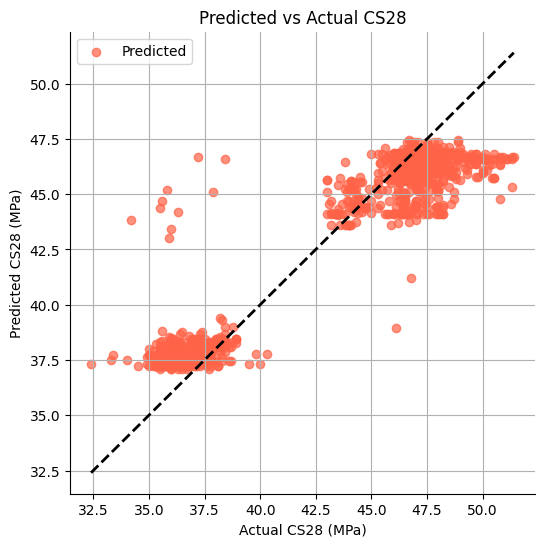

<IPython.core.display.Javascript object>

In [64]:
# Scatter plot of actual vs predicted values
test_data = df_pred[df_pred["SET"] == "TEST"]
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# plt.savefig(
#     "inn_cm_p_tiss_scpm_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches="tight"
# )
plt.show()

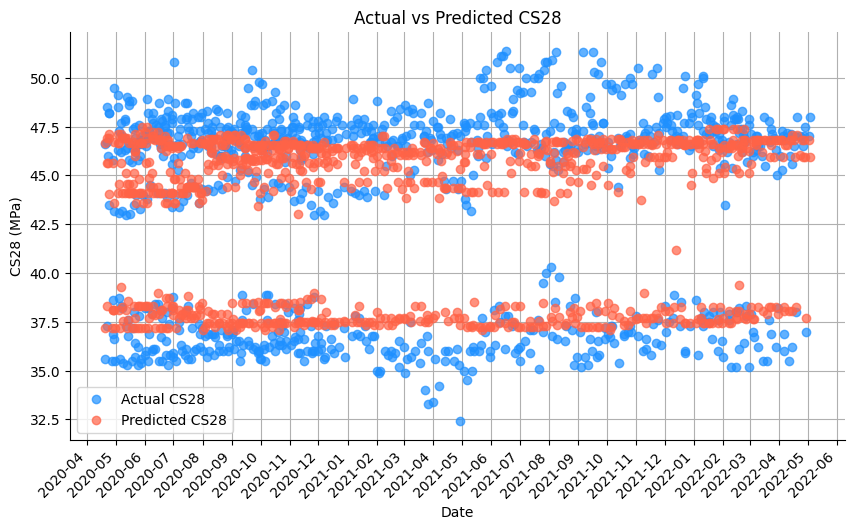

<IPython.core.display.Javascript object>

In [65]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

# Improving x-axis readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set ticks for each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format date as 'YYYY-MM-DD'
plt.gcf().autofmt_xdate(rotation=45)  # Rotate x-axis labels

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# plt.savefig(
#     "inn_cm_p_tiss_scpm_top_one_pred_vs_actual_cs28_over_time.png",
#     dpi=300,
#     bbox_inches="tight",
# )

plt.show()


# Top two intermediate model - Transformer 1 TS

In [66]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Time
import time

# Random and os for reproducibility
import random
import os

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
import tensorflow as tf

# Processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Making keras compatible with scikit learn api
# https://scikit-learn.org/stable/developers/develop.html
from sklearn.base import BaseEstimator, RegressorMixin

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

# Converting Times Series Data to 3D format
from src.utils.split_sequences import split_sequences

# Transformer Encoder for time series data
from src.models.transformer_ts_tf import Transformer

2024-11-24 01:40:44.548520: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-24 01:40:44.550807: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-24 01:40:44.593168: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-24 01:40:44.593814: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-24 01:40:45.571049: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

<IPython.core.display.Javascript object>

## Functions and definitions

### Convert train/test data to 3D format

In [67]:
def generate_sequences_helper(
    dataset, cement_types, dates=None, timesteps=None, split_by_cement_type=False
):
    index_train = dataset["y_train"].index
    index_test = dataset["y_test"].index

    dataset["y_train"] = dataset["y_train"].reset_index(drop=True)
    dataset["y_test"] = dataset["y_test"].reset_index(drop=True)

    if dates is not None:
        dataset["dates_train"] = dates[index_train].reset_index(drop=True)
        dataset["dates_test"] = dates[index_test].reset_index(drop=True)

    dataset["cement_types_train"] = cement_types.loc[index_train].reset_index(drop=True)
    dataset["cement_types_test"] = cement_types.loc[index_test].reset_index(drop=True)

    dataset = generate_sequences(dataset, timesteps, split_by_cement_type)

    return dataset

<IPython.core.display.Javascript object>

In [68]:
def generate_sequences(dataset, timesteps, split_by_cement_type=False):
    if split_by_cement_type:
        dataset["x_train"], dataset["y_train"] = split_sequences_per_cement_type(
            pd.concat(
                [
                    dataset["dates_train"],
                    pd.DataFrame(dataset["x_train"], columns=x.columns),
                    dataset["cement_types_train"],
                    dataset["y_train"],
                ],
                axis=1,
            ),
            timesteps,
        )

        dataset["x_test"], dataset["y_test"] = split_sequences_per_cement_type(
            pd.concat(
                [
                    dataset["dates_test"],
                    pd.DataFrame(dataset["x_test"], columns=x.columns),
                    dataset["cement_types_test"],
                    dataset["y_test"],
                ],
                axis=1,
            ),
            timesteps,
        )
    else:
        dataset["x_train"], dataset["y_train"] = split_sequences(
            pd.concat(
                [
                    pd.DataFrame(dataset["x_train"], columns=x.columns),
                    dataset["y_train"],
                ],
                axis=1,
            ).values,
            timesteps,
        )

        dataset["x_test"], dataset["y_test"] = split_sequences(
            pd.concat(
                [
                    pd.DataFrame(dataset["x_test"], columns=x.columns),
                    dataset["y_test"],
                ],
                axis=1,
            ).values,
            timesteps,
        )
    return dataset

<IPython.core.display.Javascript object>

In [69]:
def impute_data(dataset, imputer=None, imputer_params=None):
    x_train = dataset["x_train"]
    x_test = dataset["x_test"]

    # Apply imputation to the data
    if imputer is not None:
        imputer = imputer() if imputer_params is None else imputer(**imputer_params)
        x_train = imputer.fit_transform(x_train)
        x_test = imputer.transform(x_test)

    dataset["x_train"] = x_train
    dataset["x_test"] = x_test

    return imputer, dataset

<IPython.core.display.Javascript object>

In [70]:
def transform_data(dataset, transformer=None):
    x_train = dataset["x_train"]
    x_test = dataset["x_test"]

    # Apply data normalization/standardization to the data
    if transformer is not None:
        scaler = transformer()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

    dataset["x_train"] = x_train
    dataset["x_test"] = x_test

    return scaler, dataset

<IPython.core.display.Javascript object>

In [71]:
def preprocess_data(dataset, transformer=None, imputer=None, imputer_params=None):
    imputer, dataset = impute_data(dataset, imputer, imputer_params)
    scaler, dataset = transform_data(dataset, transformer)
    return imputer, scaler, dataset

<IPython.core.display.Javascript object>

### Train and evaluate the model

In [72]:
def train_and_evaluate_model(Estimator, dataset, estimator_params=None):
    """
    Purpose: Helper function to be used in conjunction with
    blocked time_series cross validation function
    """
    x_train = dataset["x_train"]
    y_train = dataset["y_train"]
    x_test = dataset["x_test"]
    y_test = dataset["y_test"]

    # Instantiate the model
    model = Estimator() if estimator_params is None else Estimator(**estimator_params)

    # Fitting the model
    model.fit(x_train, y_train)

    # Making predictions on train/test sets
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Return regression metrics
    return model, score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)

<IPython.core.display.Javascript object>

### Custom Cross Validate

In [73]:
# def custom_cross_validate(
#     Estimator,
#     Imputer,
#     Transform,
#     x,
#     y,
#     cv,
#     timesteps,
#     dates=None,
#     cement_types=None,
#     estimator_params=None,
#     imputer_params=None,
#     split_by_cement_type=True,
# ):
#     results = []
#     scores = []
#     scores_estimators_and_indexes = {
#         "pipeline": [],
#         "indices": {"train": [], "test": []},
#     }

#     for train_index, test_index in cv.split(x):
#         dataset = {
#             "dates_train": dates[train_index].reset_index(drop=True),
#             "cement_types_train": cement_types.loc[train_index].reset_index(drop=True),
#             "x_train": x.loc[train_index].reset_index(drop=True),
#             "y_train": y[train_index].reset_index(drop=True),
#             "dates_test": dates[test_index].reset_index(drop=True),
#             "cement_types_test": cement_types.loc[test_index].reset_index(drop=True),
#             "x_test": x.loc[test_index].reset_index(drop=True),
#             "y_test": y[test_index].reset_index(drop=True),
#         }

#         # Preprocess the dataset
#         imputer, scaler, dataset = preprocess_data(
#             dataset, Transform, Imputer, imputer_params
#         )

#         # generate sequences (3D format)
#         dataset = generate_sequences(dataset, timesteps, split_by_cement_type)

#         # Train and Evaluate the model
#         estimator, score = train_and_evaluate_model(
#             Estimator, dataset, estimator_params
#         )
#         scores.append(score)
#         scores_estimators_and_indexes["pipeline"].append([imputer, scaler, estimator])
#         scores_estimators_and_indexes["indices"]["train"].append(train_index)
#         scores_estimators_and_indexes["indices"]["test"].append(test_index)

#     # After every iteration metrics results are appended together
#     scores_final = {key: [] for key, _ in scores[0].items()}
#     for scores_dict in scores:
#         for key, value in scores_dict.items():
#             scores_final[key] += [value]
#     results.append(scores_final)
#     return scores_estimators_and_indexes, results

<IPython.core.display.Javascript object>

In [74]:
def custom_cross_validate(
    Estimator,
    Imputer,
    Transform,
    x,
    y,
    cv,
    timesteps,
    dates=None,
    cement_types=None,
    estimator_params=None,
    imputer_params=None,
    split_by_cement_type=True,
):
    scores = []
    pipelines = []
    indices = {"train": [], "test": []}

    for train_index, test_index in cv.split(x):
        dataset = {
            "dates_train": dates.iloc[train_index].reset_index(drop=True),
            "cement_types_train": cement_types.iloc[train_index].reset_index(drop=True),
            "x_train": x.iloc[train_index].reset_index(drop=True),
            "y_train": y.iloc[train_index].reset_index(drop=True),
            "dates_test": dates.iloc[test_index].reset_index(drop=True),
            "cement_types_test": cement_types.iloc[test_index].reset_index(drop=True),
            "x_test": x.iloc[test_index].reset_index(drop=True),
            "y_test": y.iloc[test_index].reset_index(drop=True),
        }

        # Preprocess the dataset
        imputer, scaler, dataset = preprocess_data(
            dataset, Transform, Imputer, imputer_params
        )

        # Generate sequences (3D format)
        dataset = generate_sequences(dataset, timesteps, split_by_cement_type)

        # Train and Evaluate the model
        estimator, score = train_and_evaluate_model(
            Estimator, dataset, estimator_params
        )
        scores.append(score)
        pipelines.append((imputer, scaler, estimator))
        indices["train"].append(train_index)
        indices["test"].append(test_index)

    return pipelines, indices, scores

<IPython.core.display.Javascript object>

## Model Definition

In [75]:
class TransformerWrapper(RegressorMixin):
    def __init__(self, params):
        self.params = params
        self.model = self.get_model()
        self.batch_size = 16
        self.epochs = 300
        self.verbose = 0

    def fit(self, X=None, y=None):
        self.model.fit(
            X, y, batch_size=self.batch_size, epochs=self.epochs, verbose=self.verbose
        )

    def predict(self, X=None):
        return self.model.predict(X, verbose=self.verbose)

    def get_model(self):
        model = Transformer(
            num_hid=self.params["num_features"],
            time_steps=self.params["timesteps"],
            num_head=self.params["num_heads"],
            num_layers_enc=self.params["num_layers_enc"],
            num_feed_forward=self.params["num_feed_forward"],
        )
        model.compile(
            tf.keras.optimizers.Adam(learning_rate=0.001),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
        )
        return model

<IPython.core.display.Javascript object>

In [76]:
def pad_time_series(dataframe, timesteps):
    """
    Pad timeseries with zeros
    """
    df_tmp = pd.DataFrame(
        dict(
            zip(
                dataframe.columns,
                [[0 for _ in range(timesteps - 1)] for _ in range(dataframe.shape[1])],
            )
        )
    )
    df_tmp[DATE] = dataframe[DATE].iloc[0]
    return pd.concat([df_tmp, dataframe], axis=0).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [77]:
def split_sequences_per_cement_type(dataframe, timesteps, pad=False):
    """
    Create sequences per cement time
    to avoid having parts of the sequence
    of different types of cement.
    """
    if timesteps == 1:
        return split_sequences(
            dataframe.drop([DATE] + CEMENT_TYPES, axis=1).values, timesteps
        )

    dates = dataframe[DATE][timesteps - 1 :]
    data = []
    dataframes = []

    for cement_type in CEMENT_TYPES:
        data.append(dataframe[dataframe[cement_type] == 1])
    data.append(dataframe[(dataframe[CEMENT_TYPES] == 0).all(axis=1)])

    for df in data:
        if pad:
            dates = df[DATE].reset_index(drop=True)
            df = pad_time_series(df, timesteps).reset_index(drop=True)
        else:
            dates = df[DATE][timesteps - 1 :].reset_index(drop=True)
        x, y = split_sequences(df.drop([DATE] + CEMENT_TYPES, axis=1).values, timesteps)
        x = pd.DataFrame({"Sequences": [sample.tolist() for sample in x]})
        y = pd.DataFrame({"Target": y})
        dataframes.append(pd.concat([dates, x, y], axis=1))

    data = pd.concat(dataframes, axis=0)
    data[DATE] = pd.to_datetime(data[DATE])
    data = data.sort_values(by=DATE).reset_index(drop=True)
    x = data["Sequences"]
    y = data["Target"].values
    x = np.array(x.tolist())

    return x, y

<IPython.core.display.Javascript object>

In [78]:
def merge_dicts(dicts):
    """Merges dicts in a list, preserving multiple values for each key.

    Args:
        dicts (list): The list of dicts to merge.

    Returns:
        list: A list of merged dicts.
    """

    merged_dicts = {}
    for d in dicts:
        for key, value in d.items():
            merged_dicts.setdefault(key, []).append(value)
    return merged_dicts

<IPython.core.display.Javascript object>

# Settings for Reproducibility

In [79]:
def set_seeds():
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    os.environ["PYTHONHASHSEED"] = str(SEED)
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)


# https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed

<IPython.core.display.Javascript object>

In [80]:
def set_global_determinism():
    set_seeds(seed=SEED)

    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

<IPython.core.display.Javascript object>

In [81]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}
DATE = "Date"
CEMENT_TYPES = ["Cement_Type_CP II-F-40", "Cement_Type_CP V-ARI"]

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [82]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_i",
    "Features": "Chemical + Mineralogical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Transformer",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [83]:
df = pd.read_csv("../../../../data/processed/partner_i-Oficial/cement-shipping.csv")

<IPython.core.display.Javascript object>

In [84]:
df_copy = df.copy()
df_copy = pd.get_dummies(data=df_copy, columns=["Cement_Type"], drop_first=True)

df_copy = df_copy.drop(
    [
        # Properties
        "CS3",
        "CS7",
        
        # Removing One-Hot encoding variables
        #"Cement_Type",
        
        
        # Chemical Composition
        # Reason: Loss on Ignition is the only feature
        # that belongs to chemical composition in which was 
        # measured by a different method, namely manual
        
    ],
    axis=1,
).copy()


<IPython.core.display.Javascript object>

<h2>1. Dataset: df_copy</h2> <br>In this dataset all features are used.

In [85]:
df_copy[CEMENT_TYPES] = df_copy[CEMENT_TYPES].astype(int)
dates = df["Date"].copy()
y = df_copy.pop("CS28")
x = df_copy
df_copy = pd.concat([x, y], axis=1)

<IPython.core.display.Javascript object>

In [86]:
TIMESTEPS_LIST = [1]

<IPython.core.display.Javascript object>

# Transformer Encoder

# Configs:

1. TIMESTEPS: 1, 3, 5, 7, 10, 15, 20

2. Epochs: 300

3. Batch size: 16

4. num heads: 1

5. FF Layers enc: 1

      5.1 Units 16

6. Optimization Algorithm: Adam
    
    6.1. Learning Rate: 1e-3

In [87]:
params = {}
params["timesteps"] = None
params["num_features"] = None
params["num_heads"] = 1
params["num_layers_enc"] = 1
params["num_feed_forward"] = 16

<IPython.core.display.Javascript object>

## 1.3. Time Series Split Cross Validation

The training set has size i * n_samples // (n_splits + 1) + n_samples % (n_splits + 1) in the i th split, with a test set of size n_samples//(n_splits + 1) by default, where n_samples is the number of samples.


<b>Dataset shape:</b> (1234, 38)<br>
<b>Splits:</b>10<br>    
    1. Train: 10 folds of 114, 226, 338, 450, 562, 675, 787, 899, 1011, 1123 samples each fold
    2. Test: 112 samples each fold
<b>Total:</b> 10 models<br>

In [88]:
set_seeds()
start = time.time()
gap = 0
n_splits = 5
repeats = 3
TIMESTEPS_LIST = [1]
timesteps = 1

print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()

pipelines_final = []
indices_final = {"train": [], "test": []}
scores_final = []


for _ in range(repeats):
    x = df_copy.drop(["Date", "CS28"] + CEMENT_TYPES, axis=1)
    y = df_copy["CS28"]
    params["num_features"] = x.shape[-1]

    cv = TimeSeriesSplit(
        gap=gap, max_train_size=None, n_splits=n_splits, test_size=None
    )
    pipelines, indices, scores = custom_cross_validate(
        TransformerWrapper,
        SimpleImputer,
        StandardScaler,
        x,
        y,
        cv,
        timesteps,
        dates=dates,
        cement_types=df_copy[CEMENT_TYPES],
        estimator_params={"params": params},
        imputer_params={"strategy": "median"},
    )

    # Collect results
    pipelines_final.extend(pipelines)
    indices_final["train"].extend(indices["train"])
    indices_final["test"].extend(indices["test"])
    scores_final.extend(scores)

scores_merged = merge_dicts(scores)
print("TIMESTEPS: %d " % timesteps)
print_scores(scores_merged, METRICS, METRICS_DICT)

end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

Blocking Time Series Split:
Repeats: 3
n_splits: 5



2024-11-24 01:40:49.207269: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


TIMESTEPS: 1 
******
[TRAIN]
******
RMSE: 0.821 (0.127)
MAE: 0.677 (0.143)
MAPE: 0.016 (0.003)
R2: 0.971 (0.010)


******
[TEST]
******
RMSE: 1.845 (0.332)
MAE: 1.351 (0.177)
MAPE: 0.032 (0.004)
R2: 0.864 (0.043)


Minutes Elapsed:  17.14917870759964


<IPython.core.display.Javascript object>

In [89]:
# Store predictions for each fold
all_predictions = []
cement_types=df_copy[CEMENT_TYPES]
params["timesteps"]=timesteps

for idx, (imputer, scaler, estimator) in enumerate(pipelines_final):
    train_index = indices_final["train"][idx]
    test_index = indices_final["test"][idx]
    
    # Prepare dataset for prediction
    dataset = {
        "dates_train": dates.iloc[train_index].reset_index(drop=True),
        "cement_types_train": cement_types.iloc[train_index].reset_index(drop=True),
        "x_train": x.iloc[train_index].reset_index(drop=True),
        "y_train": y.iloc[train_index].reset_index(drop=True),
        "dates_test": dates.iloc[test_index].reset_index(drop=True),
        "cement_types_test": cement_types.iloc[test_index].reset_index(drop=True),
        "x_test": x.iloc[test_index].reset_index(drop=True),
        "y_test": y.iloc[test_index].reset_index(drop=True),
    }

    # Apply preprocessing
    dataset["x_train"] = imputer.transform(dataset["x_train"])
    dataset["x_test"] = imputer.transform(dataset["x_test"])

    dataset["x_train"] = scaler.transform(dataset["x_train"])
    dataset["x_test"] = scaler.transform(dataset["x_test"])

    # Generate sequences
    dataset = generate_sequences(dataset, params["timesteps"], split_by_cement_type=True)

    # Adjust dates for sequences
    dates_train = dataset["dates_train"][params["timesteps"] - 1:].reset_index(drop=True)
    dates_test = dataset["dates_test"][params["timesteps"] - 1:].reset_index(drop=True)

    # Make predictions
    y_train_pred = estimator.predict(dataset["x_train"]).flatten()
    y_test_pred = estimator.predict(dataset["x_test"]).flatten()

    # Store predictions along with fold information
    fold_predictions_train = pd.DataFrame({
        "DATE": dates_train,
        "CS28": dataset["y_train"],
        "CS28_PRED": y_train_pred,
        "SET": ["TRAIN"] * len(y_train_pred),
        "FOLD": [idx + 1] * len(y_train_pred),
        "REPEAT": [(idx) // 5] * len(y_train_pred),
    })

    fold_predictions_test = pd.DataFrame({
        "DATE": dates_test,
        "CS28": dataset["y_test"],
        "CS28_PRED": y_test_pred,
        "SET": ["TEST"] * len(y_test_pred),
        "FOLD": [idx + 1] * len(y_test_pred),
        "REPEAT": [(idx) // 5] * len(y_test_pred),
    })

    all_predictions.append(pd.concat([fold_predictions_train, fold_predictions_test], axis=0))


<IPython.core.display.Javascript object>

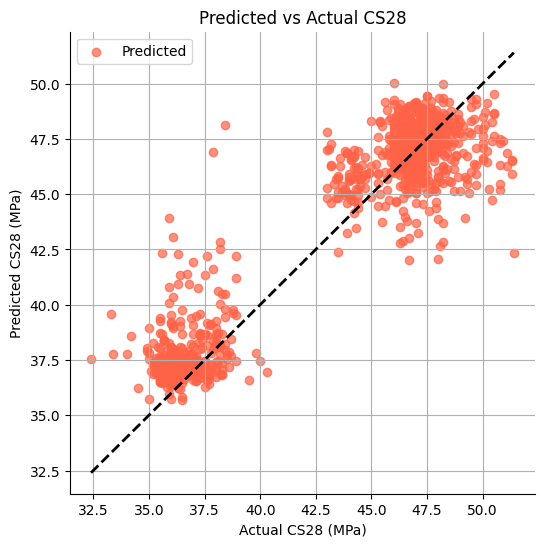

<IPython.core.display.Javascript object>

In [90]:
df_pred = pd.concat(all_predictions).reset_index(drop=True)
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

# Proceed with your plotting code
# Scatter plot of actual vs predicted values
test_data = df_pred[df_pred["SET"] == "TEST"]

test_data_tmp = test_data[test_data["REPEAT"].eq(0)].copy().reset_index(drop=True)

mean = pd.concat(
    [
        test_data[test_data["REPEAT"].eq(0)]["CS28_PRED"].reset_index(drop=True),
        test_data[test_data["REPEAT"].eq(1)]["CS28_PRED"].reset_index(drop=True),
        test_data[test_data["REPEAT"].eq(2)]["CS28_PRED"].reset_index(drop=True),
    ],
    axis=1,
).mean(axis=1)

test_data_tmp["CS28_PRED"] = mean
test_data = test_data_tmp

# test_data = test_data.groupby("INDEX", as_index=False).agg(
#     {"DATE": "first", "CS28": "first", "CS28_PRED": "mean", "SET": "first", "FOLD": "first"}
# )
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# plt.savefig(
#     "inn_cm_tiss_dominant_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches="tight"
# )
plt.show()

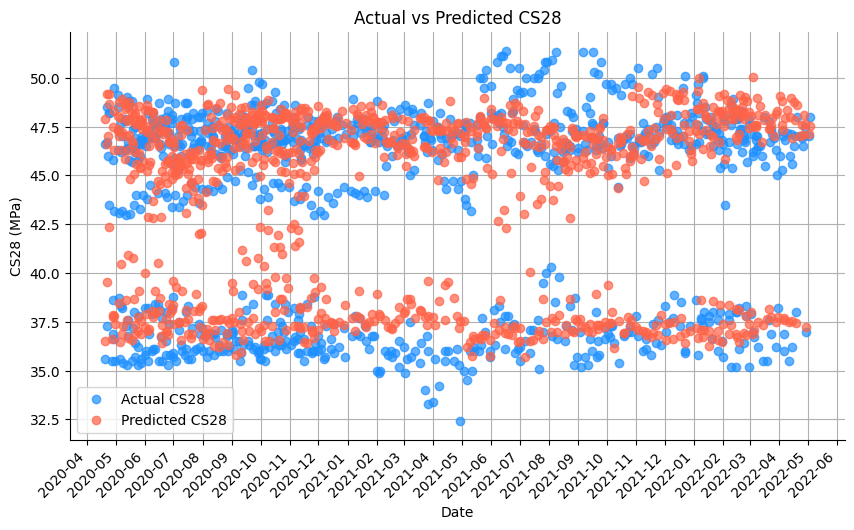

<IPython.core.display.Javascript object>

In [91]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

# Improving x-axis readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set ticks for each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format date as 'YYYY-MM-DD'
plt.gcf().autofmt_xdate(rotation=45)  # Rotate x-axis labels

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

# plt.savefig(
#     "inn_cm_tiss_dominant_top_one_pred_vs_actual_cs28_over_time.png",
#     dpi=300,
#     bbox_inches="tight",
# )

plt.show()


In [92]:
def compute_scmp(y_true, y_pred):
    # Compute the performance metrics
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    # Create a DataFrame with these metrics
    metrics_df = pd.DataFrame(
        {"RMSE Test": [rmse], "MAE Test": [mae], "MAPE Test": [mape], "R2 Test": [r2]}
    )

    # Standardize the metrics
    scaler = StandardScaler(with_mean=False)
    standardized_metrics = scaler.fit_transform(metrics_df)

    # Creating a new DataFrame with standardized values
    standardized_df = pd.DataFrame(
        standardized_metrics,
        columns=["RMSE Test", "MAE Test", "MAPE Test", "R2 Test"],
    )

    # Compute SCPM: sum errors and subtract R2
    scpm = (
        standardized_df["RMSE Test"]
        + standardized_df["MAE Test"]
        + standardized_df["MAPE Test"]
        - standardized_df["R2 Test"]
    )

    return scpm.iloc[0]  # Return the scalar SCPM score

<IPython.core.display.Javascript object>

In [93]:
def permutation_importance_seq(model, X, y, metric, n_repeats=5):
    """
    Computes permutation importance for sequence models with 3D input.
    """
    baseline_score = metric(y, model.predict(X))
    num_features = X.shape[2]  # Number of features
    importances = np.zeros(num_features)
    set_seeds()
    for i in range(num_features):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            # Shuffle feature i across samples, keeping time steps intact
            for t in range(X.shape[1]):
                # Extract the feature values at time t
                feature_values = X_permuted[:, t, i]
                np.random.shuffle(feature_values)
                X_permuted[:, t, i] = feature_values
            # Compute metric with permuted data
            permuted_score = metric(y, model.predict(X_permuted))
            scores.append(permuted_score)
        # Importance is the increase in metric when the feature is permuted
        importances[i] = baseline_score - np.mean(scores)
    return importances

<IPython.core.display.Javascript object>

In [94]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from tqdm import tqdm

feature_importances = []

for idx, (imputer, scaler, estimator) in tqdm(enumerate(pipelines_final)):
    train_index = indices_final["train"][idx]
    x_train = x.iloc[train_index].reset_index(drop=True)
    y_train = y.iloc[train_index].reset_index(drop=True)

    test_index = indices_final["test"][idx]
    x_test = x.iloc[test_index].reset_index(drop=True)
    y_test = y.iloc[test_index].reset_index(drop=True)

    # Preprocess x_test
    x_test_imputed = imputer.transform(x_test)
    x_test_scaled = scaler.transform(x_test_imputed)

    # Generate sequences
    dataset = {
        "x_train": x_test_scaled,
        "y_train": y_test,
        "x_test": x_test_scaled,
        "y_test": y_test,
    }
    dataset = generate_sequences(
        dataset, params["timesteps"], split_by_cement_type=False
    )
    x_test_seq = dataset["x_test"]
    y_test_seq = dataset["y_test"]

    # Compute permutation importance
    importances = permutation_importance_seq(
        estimator, x_test_seq, y_test_seq, r2_score, n_repeats=10
    )
    feature_importances.append(importances)

15it [06:11, 24.78s/it]


<IPython.core.display.Javascript object>

In [95]:
import numpy as np
import pandas as pd

# Average importances across folds
mean_importances = np.mean(feature_importances, axis=0)

# importances_df = pd.DataFrame(feature_importances, columns=x.columns)
# Transpose the list of arrays so that each row corresponds to a permutation/model, and each column to a feature
importances_df = pd.DataFrame(feature_importances)

# Assign the feature names to the columns
importances_df.columns = x.columns

# Map importances to feature names
importances_df_mean = (
    importances_df.mean(axis=0)
    .to_frame()
    .reset_index(0)
    .rename({"index": "Feature", 0: "Importance"}, axis=1)
)

<IPython.core.display.Javascript object>

In [96]:
rename_dict = {
    "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
    "Beta C2S": r"Beta $\mathrm{C_2S}$",
    "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
    "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
    "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
    "K2O": r"$\mathrm{K_2O}$",
    "Free CaO": r"Free $\mathrm{CaO}$",
    "Total C2S": r"Total $\mathrm{C_2S}$",
    "Na2O": r"$\mathrm{Na_2O}$",
    "CaO": r"$\mathrm{CaO}$",
    "SiO2": r"$\mathrm{SiO_2}$",
    "MgO": r"$\mathrm{MgO}$",
    "Fe2O3": r"$\mathrm{Fe_2O_3}$",
    "Al2O3": r"$\mathrm{Al_2O_3}$",
    "Total C3S": r"Total $\mathrm{C_3S}$",
    "C3A": r"$\mathrm{C_3A}$",
    "C4AF": r"$\mathrm{C_4AF}$",
    "LOI": "LOI",
    "SO3": r"$\mathrm{SO_3}$",
}


importances_df = importances_df.rename(rename_dict, axis=1)
importances_df_mean["Feature"] = importances_df_mean["Feature"].replace(rename_dict)

<IPython.core.display.Javascript object>

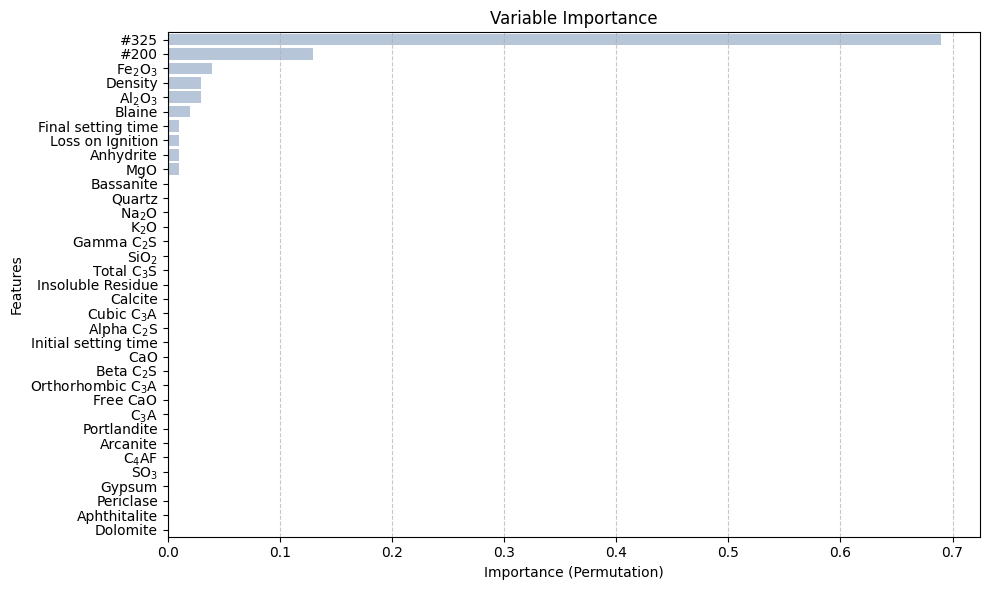

<IPython.core.display.Javascript object>

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort importances
mean_importances_df = importances_df_mean.sort_values(by='Importance', ascending=False).round(2)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=mean_importances_df, color="lightsteelblue")
plt.title("Variable Importance")
plt.xlabel("Importance (Permutation)")
plt.ylabel("Features")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
# plt.savefig(
#     "variable_relevance.png",
#     dpi=300,
#     bbox_inches="tight",
# )
plt.show()


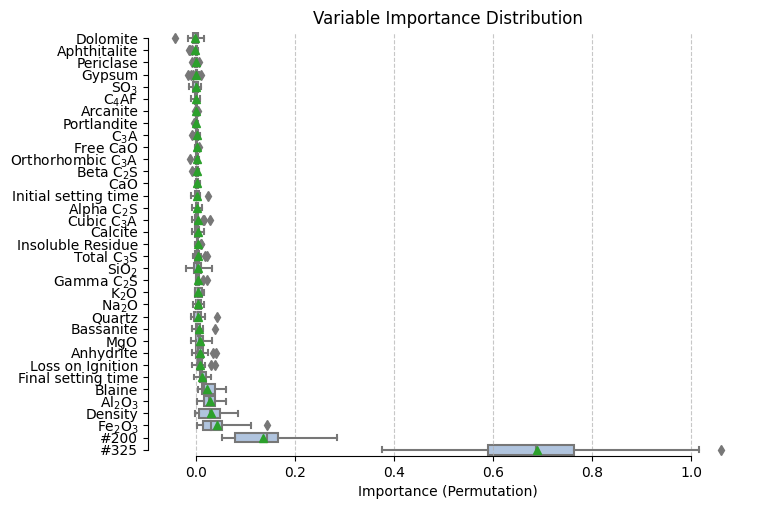

<IPython.core.display.Javascript object>

In [98]:
perm_importances_df = importances_df


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
# plt.savefig(
#     "inn_cm_tiss_transformer_scpm_best_dist_var_perm_relevance.png",
#     dpi=300,
#     bbox_inches="tight",
# )
plt.show()

In [99]:
perm_importances_df.columns

Index(['Dolomite', 'Aphthitalite', 'Periclase', 'Gypsum', '$\mathrm{SO_3}$',
       '$\mathrm{C_4AF}$', 'Arcanite', 'Portlandite', '$\mathrm{C_3A}$',
       'Free $\mathrm{CaO}$', 'Orthorhombic $\mathrm{C_3A}$',
       'Beta $\mathrm{C_2S}$', '$\mathrm{CaO}$', 'Initial setting time',
       'Alpha $\mathrm{C_2S}$', 'Cubic $\mathrm{C_3A}$', 'Calcite',
       'Insoluble Residue', 'Total $\mathrm{C_3S}$', '$\mathrm{SiO_2}$',
       'Gamma $\mathrm{C_2S}$', '$\mathrm{K_2O}$', '$\mathrm{Na_2O}$',
       'Quartz', 'Bassanite', '$\mathrm{MgO}$', 'Anhydrite',
       'Loss on Ignition', 'Final setting time', 'Blaine',
       '$\mathrm{Al_2O_3}$', 'Density', '$\mathrm{Fe_2O_3}$', '#200', '#325'],
      dtype='object')

<IPython.core.display.Javascript object>

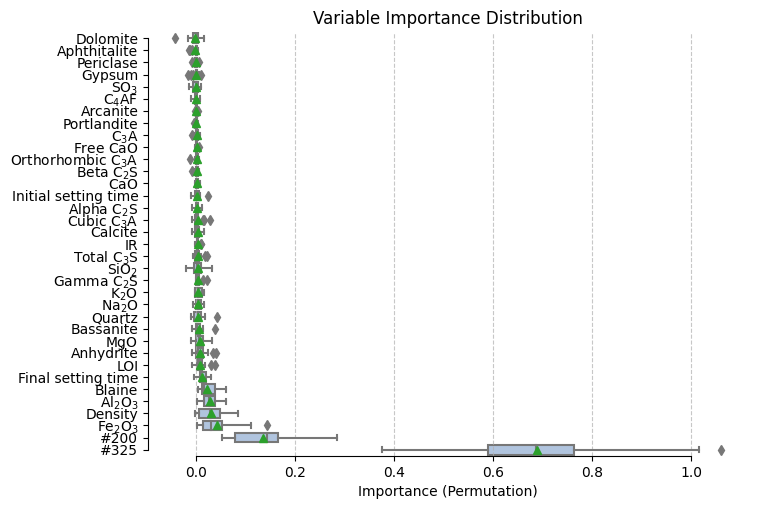

<IPython.core.display.Javascript object>

In [100]:
# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "Alpha C2S": r"Alpha $\mathrm{C_2S}$",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "Gamma C2S": r"Gamma $\mathrm{C_2S}$",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "Loss on Ignition": "LOI",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
# plt.savefig(
#     "inn_cm_tiss_transformer_scpm_best_dist_var_perm_relevance.png",
#     dpi=300,
#     bbox_inches="tight",
# )


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

plt.show()

In [101]:
perm_importances_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Dolomite,15.0,-0.002766,0.013847,-0.042644,-5.957540e-03,0.000136,0.002781,0.015631
Aphthitalite,15.0,-0.001943,0.005690,-0.015603,-1.661431e-03,-0.000202,0.001676,0.003499
Periclase,15.0,-0.001182,0.002797,-0.008363,-2.495177e-03,-0.000999,0.000184,0.004481
Gypsum,15.0,-0.001182,0.006298,-0.017192,-9.890429e-04,0.000040,0.001893,0.008247
$\mathrm{SO_3}$,15.0,-0.000852,0.007107,-0.014029,-5.964938e-03,-0.000845,0.003417,0.009852
$\mathrm{C_4AF}$,15.0,-0.000804,0.004744,-0.010068,-3.460094e-03,-0.001070,0.001648,0.007694
Arcanite,15.0,0.000062,0.001683,-0.003481,-6.635825e-04,-0.000042,0.000767,0.003971
Portlandite,15.0,0.000111,0.001936,-0.005239,-1.227034e-04,0.000594,0.001063,0.002834
$\mathrm{C_3A}$,15.0,0.000343,0.004318,-0.009869,-1.592461e-03,-0.001078,0.003538,0.006348
Free $\mathrm{CaO}$,15.0,0.000432,0.002449,-0.002722,-1.231410e-03,-0.000190,0.001259,0.005641


<IPython.core.display.Javascript object>